You may have disagreed with the original statement that the Law of Large numbers is known to everyone, but only implicitly in our subconscious decision making. Consider ratings on online products: how often do you trust an average 5-star rating if there is only 1 reviewer? 2 reviewers? 3 reviewers? We implicitly understand that with such few reviewers that the average rating is not a good reflection of the true value of the product.

This has created flaws in how we sort items, and more generally, how we compare items. Many people have realized that sorting online search results by their rating, whether the objects be books, videos, or online comments, return poor results. Often the seemingly top videos or comments have perfect ratings only from a few enthusiastic fans, and truly more quality videos or comments are hidden in later pages with falsely-substandard ratings of around 4.8. How can we correct this?

Consider the popular site Reddit (I purposefully did not link to the website as you would never come back). The site hosts links to stories or images, called submissions, for people to comment on. Redditors can vote up or down on each submission (called upvotes and downvotes). Reddit, by default, will sort submissions to a given subreddit by Hot, that is, the submissions that have the most upvotes recently.

How would you determine which submissions are the best? There are a number of ways to achieve this:
1. *Popularity*: A submission is considered good if it has many upvotes. A problem with this model is that a submission with hundreds of upvotes, but thousands of downvotes. While being very popular, the submission is likely more controversial than best.
2. *Difference*: Using the difference of upvotes and downvotes. This solves the above problem, but fails when we consider the temporal nature of submission. Depending on when a submission is posted, the website may be experiencing high or low traffic. The difference method will bias the Top submissions to be the those made during high traffic periods, which have accumulated more upvotes than submissions that were not so graced, but are not necessarily the best.
3. *Time adjusted*: Consider using Difference divided by the age of the submission. This creates a rate, something like difference per second, or per minute. An immediate counter-example is, if we use per second, a 1 second old submission with 1 upvote would be better than a 100 second old submission with 99 upvotes. One can avoid this by only considering at least t second old submission. But what is a good t value? Does this mean no submission younger than t is good? We end up comparing unstable quantities with stable quantities (young vs. old submissions).
4. *Ratio*: Rank submissions by the ratio of upvotes to total number of votes (upvotes plus downvotes). This solves the temporal issue, such that new submissions who score well can be considered Top just as likely as older submissions, provided they have many upvotes to total votes. The problem here is that a submission with a single upvote (ratio = 1.0) will beat a submission with 999 upvotes and 1 downvote (ratio = 0.999), but clearly the latter submission is more likely to be better.

I used the phrase more likely for good reason. It is possible that the former submission, with a single upvote, is in fact a better submission than the later with 999 upvotes. The hesitation to agree with this is because we have not seen the other 999 potential votes the former submission might get. Perhaps it will achieve an additional 999 upvotes and 0 downvotes and be considered better than the latter, though not likely.

What we really want is an estimate of the true upvote ratio. Note that the true upvote ratio is not the same as the observed upvote ratio: the true upvote ratio is hidden, and we only observe upvotes vs. downvotes (one can think of the true upvote ratio as "what is the underlying probability someone gives this submission a upvote, versus a downvote"). So the 999 upvote/1 downvote submission probably has a true upvote ratio close to 1, which we can assert with confidence thanks to the Law of Large Numbers, but on the other hand we are much less certain about the true upvote ratio of the submission with only a single upvote. Sounds like a Bayesian problem to me.

One way to determine a prior on the upvote ratio is to look at the historical distribution of upvote ratios. This can be accomplished by scraping Reddit's submissions and determining a distribution. There are a few problems with this technique though:

1. Skewed data: The vast majority of submissions have very few votes, hence there will be many submissions with ratios near the extremes (see the "triangular plot" in the above Kaggle dataset), effectively skewing our distribution to the extremes. One could try to only use submissions with votes greater than some threshold. Again, problems are encountered. There is a tradeoff between number of submissions available to use and a higher threshold with associated ratio precision.
2. Biased data: Reddit is composed of different subpages, called subreddits. Two examples are r/aww, which posts pics of cute animals, and r/politics. It is very likely that the user behaviour towards submissions of these two subreddits are very different: visitors are likely friendly and affectionate in the former, and would therefore upvote submissions more, compared to the latter, where submissions are likely to be controversial and disagreed upon. Therefore not all submissions are the same.

In light of these, I think it is better to use a `Uniform` prior.

In [2]:
from default_settings import *

In [15]:
import sys
import numpy as np
from IPython.core.display import Image
import praw

reset_sess()

enter_client_id = '_Ez243iFWrDKJA'
enter_client_secret = 'QnQffhr_PTWsuG6amB8nx2dYaQ8'
enter_user_agent = 'Bayesian'
enter_username = 'yl238'
enter_password = '7erstarrung'

subreddit_name = "showerthoughts"

reddit = praw.Reddit(client_id=enter_client_id,
                    client_secret=enter_client_secret,
                    user_agent=enter_user_agent,
                    username=enter_username,
                    password=enter_password)
subreddit = reddit.subreddit(subreddit_name)

timespan = 'day' #@param ['hour', 'day', 'week', 'month', 'year', 'all']

top_submissions = subreddit.top(timespan)

#adding a number to the inside of int() call will get the ith top post.
ith_top_post = 2   #@param {type:"number"}
n_sub = int(ith_top_post)

i = 0
while i < n_sub:
    top_submission = next(top_submissions)
    i += 1

top_post = top_submission.title

upvotes = []
downvotes = []
contents = []

for sub in top_submissions:
    try:
        ratio = sub.upvote_ratio
        ups = int(round((ratio*sub.score)/(2*ratio - 1))
                  if ratio != 0.5 else round(sub.score/2))
        upvotes.append(ups)
        downvotes.append(ups - sub.score)
        contents.append(sub.title)
    except Exception as e:
        continue
votes = np.array( [ upvotes, downvotes] ).T

print("Post contents: \n")
print(top_post)

Post contents: 

You don’t realize how violent a game is until your mom watches you play it.


In [18]:
"""
contents: an array of the text from the last 100 top submissions to a subreddit
votes: a 2d numpy array of upvotes, downvotes for each submission.
"""
n_submissions_ = len(votes)
submissions = tfd.Uniform(low=float(0.), high=float(n_submissions_)).sample(sample_shape=(4))
submissions_ = evaluate(tf.to_int32(submissions))

print("Some Submissions (out of %d total) \n-----------"%n_submissions_)
for i in submissions_:
    print('"' + contents[i] + '"')
    print("upvotes/downvotes: ",votes[i,:], "\n")

Some Submissions (out of 98 total) 
-----------
"Headphones with wires have saved millions of phones from hitting the ground."
upvotes/downvotes:  [8073  702] 

"The difference between a rebellion and a revolution is dependent on who won"
upvotes/downvotes:  [240  10] 

"Austin Powers came out in 1997, there probably aren't a lot of cats named Mr. Bigglesworth left."
upvotes/downvotes:  [50  6] 

"When you cry your brain releases an endorphin to reduce pain and better your mood. This is like the chemical equivalent of your own brain patting you on the back and saying "everything's gonna be okay.""
upvotes/downvotes:  [2635   27] 



For a given true upvote ratio $p$ and $N$ votes, the number of upvotes will look like a Binomial random variable with parameters $p$ and $N$. (This is because of the equivalence between upvote ratio and probability of upvoting versus downvoting, out of $N$ possible votes/trials). We create a function that performs Bayesian inference on $p$, for a particular submission's upvote/downvote pair.

In [19]:
def joint_log_prob(upvotes, N, test_upvote_ratio):
    tfd = tfp.distributions
    
    rv_upvote_ratio = tfd.Uniform(name="upvote_ratio", low=0., high=1.)
    rv_observations = tfd.Binomial(name="obs", total_count=float(N),
                                  probs=test_upvote_ratio)
    return (
        rv_upvote_ratio.log_prob(test_upvote_ratio)
        + tf.reduce_sum(rv_observations.log_prob(float(upvotes))))

In some cases we might want to run something like an HMC for multiple, or a variable number of inputs. Loops are common examples of this. Here we define our function for setting up an HMC that can take in different numbers of upvotes and/or downvotes.

In [20]:
def posterior_upvote_ratio(upvotes, downvotes):
    reset_sess()
    
    N = float(upvotes) + float(downvotes)
    
    # Initialize the step_size. (It will be automatically adapted)
    with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
        step_size = tf.get_variable(
            name='step_size',
            initializer=tf.constant(0.5, dtype=tf.float32),
            trainable=False,
            use_resource=True)
    # Set the chain's start date.
    initial_chain_state = [
        0.5 * tf.ones([], dtype=tf.float32, name="init_upvote_ratio")
    ]
    
    # Since HMC operates over unconstrained space, we need to transform the
    # samples so they live in real-space
    unconstraining_bijectors = [
        tfp.bijectors.Sigmoid()
    ]
    
    # Define a closure over our joint_log_prob
    unnormalized_posterior_log_prob = lambda *args: joint_log_prob(upvotes, N, *args)
    
    # Defining the HMC
    hmc = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
            state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)
    
    # Sample from the chain
    [
        posterior_upvote_ratio
    ], kernel_results = tfp.mcmc.sample_chain(
        num_results=20000,
        num_burnin_steps=5000,
        current_state=initial_chain_state,
        kernel=hmc)
    # Initialize any created variables
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    
    evaluate(init_g)
    evaluate(init_l)
    
    return evaluate([
        posterior_upvote_ratio,
        kernel_results,
    ])
    

In [22]:
plt.hist?

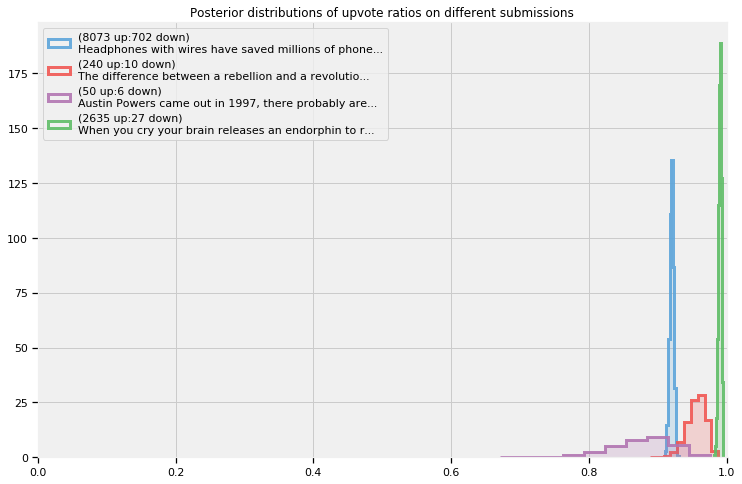

In [23]:
plt.figure(figsize(11., 8))
posteriors = []
colours = ["#5DA5DA", "#F15854", "#B276B2", "#60BD68", "#F17CB0"]
for i in range(len(submissions_)):
    j = submissions_[i]
    posteriors.append( posterior_upvote_ratio(votes[j, 0], votes[j, 1])[0] )
    plt.hist( posteriors[i], bins = 10, density = True, alpha = .9, 
            histtype="step",color = colours[i], lw = 3,
            label = '(%d up:%d down)\n%s...'%(votes[j, 0], votes[j,1], contents[j][:50]) )
    plt.hist( posteriors[i], bins = 10, density = True, alpha = .2, 
            histtype="stepfilled",color = colours[i], lw = 3, )
    
plt.legend(loc="upper left")
plt.xlim( 0, 1)
plt.title("Posterior distributions of upvote ratios on different submissions");

### Sorting!
We have been ignoring the aim of the exercise: how do we sort the submissions from *best* to *worst*? Of course we cannot sort distributions, we must sort scalar numbers. There are many ways to distill a distribution down to a scalar: expressing the distribution through its expected value, or mean is one. Choosing the mean is a bad choice though. This because the mean does not take into account the uncertainty of distributions.

I suggest using the *95% least plausible value*, defined as the value such that there is only a 5% chance the true parameter is lower (think of the lower bound on the 95% credible region). Below are the posterior distributions with the 95% least-plausible value plotted.

[3 1 0 2] [0.9150969, 0.93167335, 0.79883516, 0.9859487]


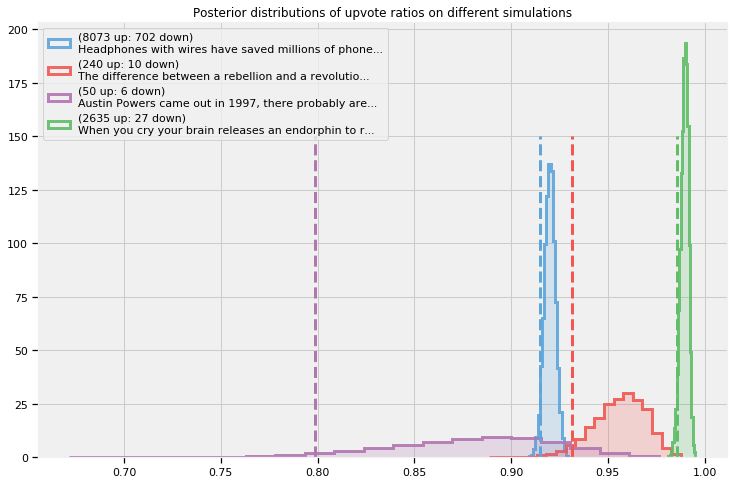

In [25]:
N = posteriors[0].shape[0]
lower_limits= []

for i in range(len(submissions_)):
    j = submissions_[i]
    plt.hist(posteriors[i], bins=20, density=True, alpha=.9, histtype='step', color=colours[i], lw=3,
            label='(%d up: %d down)\n%s...' % (votes[j, 0], votes[j, 1], contents[j][:50]))
    plt.hist(posteriors[i], bins=20, density=True, alpha=.2, histtype='stepfilled', color=colours[i], lw=3,)
    v = np.sort(posteriors[i])[int(0.05*N)]
    plt.vlines(v, 0, 150, color=colours[i], linestyles='--', linewidth=3)
    lower_limits.append(v)
    plt.legend(loc='upper left')

plt.legend(loc='upper left')
plt.title('Posterior distributions of upvote ratios on different simulations');
order = np.argsort(-np.array(lower_limits))
print(order, lower_limits)

The best submissions according to our procedure are the submissions that are *most-likely* to score a high percentage of upvotes. Visually those are the submissions with the 95% least plausible value close to 1. Under this ordering, we impose the following very natural properties:
1. Given two submissions with the same observed upvote ratio, we will assign the submission with more votes as better (since we are more confident it has a higher ratio).
2. Given two submissions with the same number of votes, we still assign the submission with more upvotes as *better*.

#### But this is too slow for real time!
Computing the posterior of every submission takes a long time, and by the time you have completed it, likely the data has changed. We can use the following formula to compute the lower bound very fast.
$$
\frac{a}{a+b}-1.65\sqrt{\frac{ab}{(a+b)^2(a+b+1)}}
$$
where
\begin{eqnarray}
a & = & 1+u\\
b & = & 1+d\\
\end{eqnarray}
$u$ is the number of upvotes, and $d$ is the number of downvotes. The formula is a shortcut in Bayesian inference, which will be further explained when we discuss priors in more details.

In [26]:
def intervals(u, d):
    a = tf.add(1., u)
    b = tf.add(1., d)
    mu = tf.divide(x=a, y=tf.add(1., u))
    std_err = 1.65 * tf.sqrt((a * b)/ ((a + b) **2 *(a + b+ 1.)))
    return mu, std_err

In [27]:
print('Approximate lower bounds:')
posterior_mean, std_err = evaluate(intervals(votes[:,0], votes[:,1]))
lb = posterior_mean - std_err
print(lb)
print('\n')
print('Top 40 sorted according to approximate lower bounds:')
print('\n')
[ order ] = evaluate([tf.nn.top_k(lb, k=lb.shape[0], sorted=True)])
ordered_contents= []
for i, N in enumerate(order.values[:40]):
    ordered_contents.append(contents[i])
    print(votes[i, 0], votes[i, 1], contents[i])
    print('------------------')

Approximate lower bounds:
[0.99521965 0.99575585 0.9954455  0.9921777  0.994286   0.9869578
 0.98875576 0.99336654 0.99674046 0.982947   0.9865956  0.9831903
 0.9860204  0.98246    0.97396916 0.9880857  0.9844959  0.9748073
 0.9679937  0.9838696  0.97880524 0.9799374  0.96582466 0.99131525
 0.96974427 0.9719071  0.98362285 0.98045474 0.9752949  0.96774584
 0.9585213  0.96368635 0.96117646 0.97053224 0.95891047 0.9698287
 0.9912142  0.95262086 0.9757237  0.97554755 0.9964935  0.95221686
 0.95456976 0.971854   0.9509203  0.9478111  0.9627752  0.95861036
 0.9461159  0.9485606  0.96004343 0.9490098  0.95416075 0.9563484
 0.9849947  0.93697715 0.94073516 0.94799423 0.9380462  0.9321255
 0.9577546  0.93857414 0.9368613  0.953262   0.93851423 0.9348654
 0.9360013  0.95798296 0.9745752  0.931328   0.9427412  0.9332762
 0.92569053 0.93530416 0.92487574 0.9255324  0.9345805  0.98426175
 0.9402789  0.9300216  0.9267209  0.93661344 0.9292639  0.92278856
 0.92226416 0.92474455 0.9738775  0.93218046

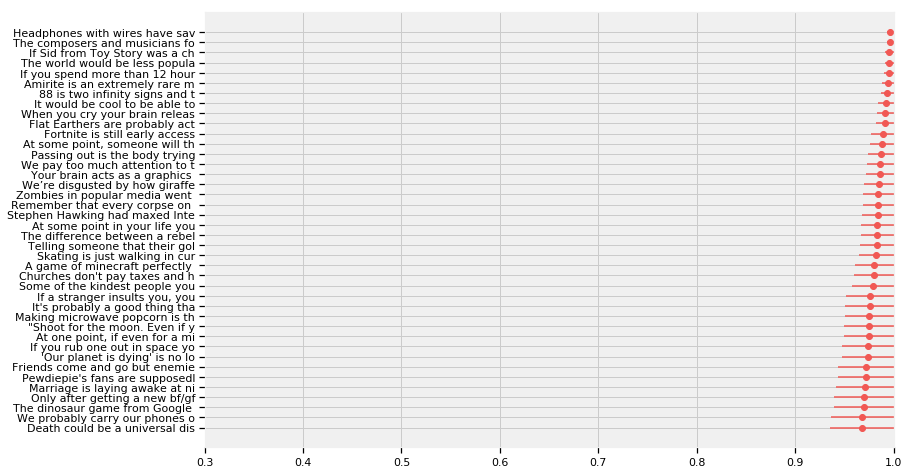

In [29]:
r_order = order.indices[::-1][-40:]
ratio_range_ = evaluate(tf.range(len(r_order)-1, -1, -1))
r_order_vals = order.values[::-1][-40:]
plt.errorbar(r_order_vals, np.arange(len(r_order)),
            xerr=std_err[r_order], capsize=0, fmt='o',
            color=TFColor[0])
plt.xlim(0.3, 1)
plt.yticks(ratio_range_, map(lambda x: x[:30].replace("\n",""), ordered_contents));

### Extension to Starred rating systems
We can consider the upvote-downvote problem above as binary: 0 is a downvote, 1 if an upvote. a $N$-start rating system can be seen as a more continuous version of above, and we can set $n$ starts rewarded is equivalent to rewarding $\frac{n}{N}$. For example, in a 5-star system, a 2-start rating corresponds to 0.4, a perfect rating is 1. We can use the same formula as before, but with $a$, $b$ defined differently:
$$
\frac{a}{a+b}-1.65\sqrt{\frac{ab}{(a+b)^2(a+b+1)}}
$$
where
$$
a = 1+S\\
b = 1+N-S
$$
where $N$ is the number of users who rated, and $S$ is the sum of all the ratings, under the equivalence scheme mentioned above.

### Example: Counting Github stars
What is the average number of stars a Github repository has? How would you calculate this? There are over 6 million repositories, so there is more than enough data to invoke the Law of Large numbers. Let's start pulling some data.

In [33]:
reset_sess()

import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter3_MCMC/data/github_data.csv'
filename = wget.download(url)
filename

'github_data.csv'

In [39]:
# Github data scrapper
# See documentation_url: https://developer.github.com/v3/

from json import loads
import datetime
import numpy as np
from requests import get

"""
variables of interest:
    indp. variables
    - language, given as a binary variable. Need 4 positions for 5 langagues
    - #number of days created ago, 1 position
    - has wiki? Boolean, 1 position
    - followers, 1 position
    - following, 1 position
    - constant
    
    dep. variables
    -stars/watchers
    -forks
"""


MAX = 8000000
today =  datetime.datetime.today()
randint = np.random.randint
N = 120 #sample size. 
auth = ("yl238", "YiYueMi1@!" )

language_mappings = {"Python": 0, "JavaScript": 1, "Ruby": 2, "Java":3, "Shell":4, "PHP":5}

#define data matrix: 
X = np.zeros( (N , 12), dtype = int )

for i in range(N):
    is_fork = True
    is_valid_language = False
    
    while is_fork == True or is_valid_language == False:
        is_fork = True
        is_valid_language = False
        
        params = {"since":randint(0, MAX ) }
        r = get("https://api.github.com/repositories", params = params, auth=auth )
        results = loads( r.text )[0]
        #im only interested in the first one, and if it is not a fork.
        print(results)
        is_fork = results["fork"]
        
        r = get( results["url"], auth = auth)
        
        #check the language
        repo_results = loads( r.text )
        try: 
            language_mappings[ repo_results["language" ] ]
            is_valid_language = True
        except:
            pass

    #languages 
    X[ i, language_mappings[ repo_results["language" ] ] ] = 1
    
    #delta time
    X[ i, 6] = ( today - datetime.datetime.strptime( repo_results["created_at"][:10], "%Y-%m-%d" ) ).days
    
    #haswiki
    X[i, 7] = repo_results["has_wiki"]
    
    #get user information
    r = get( results["owner"]["url"] , auth = auth)
    user_results = loads( r.text )
    X[i, 8] = user_results["following"]
    X[i, 9] = user_results["followers"]
    #get dep. data
    X[i, 10] = repo_results["watchers_count"]
    X[i, 11] = repo_results["forks_count"]
    print()
    print(" -------------- ")
    print(i, ": ", results["full_name"], repo_results["language" ], repo_results["watchers_count"], repo_results["forks_count"]) 
    print(" -------------- ") 
    print() 
    
np.savetxt("github_data.csv", X, delimiter=",", fmt="%d" )

{'id': 1717335, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNzE3MzM1', 'name': 'sorrell.github.com', 'full_name': 'sorrell/sorrell.github.com', 'private': False, 'owner': {'login': 'sorrell', 'id': 763445, 'node_id': 'MDQ6VXNlcjc2MzQ0NQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/763445?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/sorrell', 'html_url': 'https://github.com/sorrell', 'followers_url': 'https://api.github.com/users/sorrell/followers', 'following_url': 'https://api.github.com/users/sorrell/following{/other_user}', 'gists_url': 'https://api.github.com/users/sorrell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/sorrell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/sorrell/subscriptions', 'organizations_url': 'https://api.github.com/users/sorrell/orgs', 'repos_url': 'https://api.github.com/users/sorrell/repos', 'events_url': 'https://api.github.com/users/sorrell/events{/privacy}', 'received_events_url': 'https


 -------------- 
0 :  talkingraisin/Scrabble Java 1 0
 -------------- 

{'id': 4567960, 'node_id': 'MDEwOlJlcG9zaXRvcnk0NTY3OTYw', 'name': 'GitTest', 'full_name': 'popchieh/GitTest', 'private': False, 'owner': {'login': 'popchieh', 'id': 1177066, 'node_id': 'MDQ6VXNlcjExNzcwNjY=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1177066?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/popchieh', 'html_url': 'https://github.com/popchieh', 'followers_url': 'https://api.github.com/users/popchieh/followers', 'following_url': 'https://api.github.com/users/popchieh/following{/other_user}', 'gists_url': 'https://api.github.com/users/popchieh/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/popchieh/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/popchieh/subscriptions', 'organizations_url': 'https://api.github.com/users/popchieh/orgs', 'repos_url': 'https://api.github.com/users/popchieh/repos', 'events_url': 'https://api.github.co

{'id': 7720993, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NzIwOTkz', 'name': 'joomla-slideshow', 'full_name': 'egel/joomla-slideshow', 'private': False, 'owner': {'login': 'egel', 'id': 3322106, 'node_id': 'MDQ6VXNlcjMzMjIxMDY=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/3322106?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/egel', 'html_url': 'https://github.com/egel', 'followers_url': 'https://api.github.com/users/egel/followers', 'following_url': 'https://api.github.com/users/egel/following{/other_user}', 'gists_url': 'https://api.github.com/users/egel/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/egel/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/egel/subscriptions', 'organizations_url': 'https://api.github.com/users/egel/orgs', 'repos_url': 'https://api.github.com/users/egel/repos', 'events_url': 'https://api.github.com/users/egel/events{/privacy}', 'received_events_url': 'https://api.github.com/users/egel/received_

{'id': 2355209, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMzU1MjA5', 'name': 'first_app', 'full_name': 'NineteenHockey/first_app', 'private': False, 'owner': {'login': 'NineteenHockey', 'id': 1035670, 'node_id': 'MDQ6VXNlcjEwMzU2NzA=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1035670?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/NineteenHockey', 'html_url': 'https://github.com/NineteenHockey', 'followers_url': 'https://api.github.com/users/NineteenHockey/followers', 'following_url': 'https://api.github.com/users/NineteenHockey/following{/other_user}', 'gists_url': 'https://api.github.com/users/NineteenHockey/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/NineteenHockey/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/NineteenHockey/subscriptions', 'organizations_url': 'https://api.github.com/users/NineteenHockey/orgs', 'repos_url': 'https://api.github.com/users/NineteenHockey/repos', 'events_url': 'https://api.github.com/u

{'id': 5880855, 'node_id': 'MDEwOlJlcG9zaXRvcnk1ODgwODU1', 'name': 'css3-hover-info', 'full_name': 'darkdriving/css3-hover-info', 'private': False, 'owner': {'login': 'darkdriving', 'id': 157722, 'node_id': 'MDQ6VXNlcjE1NzcyMg==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/157722?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/darkdriving', 'html_url': 'https://github.com/darkdriving', 'followers_url': 'https://api.github.com/users/darkdriving/followers', 'following_url': 'https://api.github.com/users/darkdriving/following{/other_user}', 'gists_url': 'https://api.github.com/users/darkdriving/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/darkdriving/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/darkdriving/subscriptions', 'organizations_url': 'https://api.github.com/users/darkdriving/orgs', 'repos_url': 'https://api.github.com/users/darkdriving/repos', 'events_url': 'https://api.github.com/users/darkdriving/events

{'id': 7428324, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NDI4MzI0', 'name': 'Robotic-Vision-laboratory-exercises', 'full_name': 'udovicic/Robotic-Vision-laboratory-exercises', 'private': False, 'owner': {'login': 'udovicic', 'id': 1079201, 'node_id': 'MDQ6VXNlcjEwNzkyMDE=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1079201?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/udovicic', 'html_url': 'https://github.com/udovicic', 'followers_url': 'https://api.github.com/users/udovicic/followers', 'following_url': 'https://api.github.com/users/udovicic/following{/other_user}', 'gists_url': 'https://api.github.com/users/udovicic/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/udovicic/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/udovicic/subscriptions', 'organizations_url': 'https://api.github.com/users/udovicic/orgs', 'repos_url': 'https://api.github.com/users/udovicic/repos', 'events_url': 'https://api.github.com/users/udovicic/


 -------------- 
3 :  tedkulp/dotfiles-briefcase Shell 1 0
 -------------- 

{'id': 2769536, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNzY5NTM2', 'name': 'Nopuku', 'full_name': 'taijinlee/Nopuku', 'private': False, 'owner': {'login': 'taijinlee', 'id': 971101, 'node_id': 'MDQ6VXNlcjk3MTEwMQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/971101?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/taijinlee', 'html_url': 'https://github.com/taijinlee', 'followers_url': 'https://api.github.com/users/taijinlee/followers', 'following_url': 'https://api.github.com/users/taijinlee/following{/other_user}', 'gists_url': 'https://api.github.com/users/taijinlee/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/taijinlee/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/taijinlee/subscriptions', 'organizations_url': 'https://api.github.com/users/taijinlee/orgs', 'repos_url': 'https://api.github.com/users/taijinlee/repos', 'events_url': 'https://a

{'id': 2367802, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMzY3ODAy', 'name': 'SupplyChainPilotDev', 'full_name': 'tomekskiba/SupplyChainPilotDev', 'private': False, 'owner': {'login': 'tomekskiba', 'id': 901459, 'node_id': 'MDQ6VXNlcjkwMTQ1OQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/901459?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/tomekskiba', 'html_url': 'https://github.com/tomekskiba', 'followers_url': 'https://api.github.com/users/tomekskiba/followers', 'following_url': 'https://api.github.com/users/tomekskiba/following{/other_user}', 'gists_url': 'https://api.github.com/users/tomekskiba/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/tomekskiba/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/tomekskiba/subscriptions', 'organizations_url': 'https://api.github.com/users/tomekskiba/orgs', 'repos_url': 'https://api.github.com/users/tomekskiba/repos', 'events_url': 'https://api.github.com/users/tomekskiba/events{/pr

{'id': 3471149, 'node_id': 'MDEwOlJlcG9zaXRvcnkzNDcxMTQ5', 'name': 'Suds', 'full_name': 'muthhus/Suds', 'private': False, 'owner': {'login': 'muthhus', 'id': 84474, 'node_id': 'MDQ6VXNlcjg0NDc0', 'avatar_url': 'https://avatars3.githubusercontent.com/u/84474?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/muthhus', 'html_url': 'https://github.com/muthhus', 'followers_url': 'https://api.github.com/users/muthhus/followers', 'following_url': 'https://api.github.com/users/muthhus/following{/other_user}', 'gists_url': 'https://api.github.com/users/muthhus/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/muthhus/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/muthhus/subscriptions', 'organizations_url': 'https://api.github.com/users/muthhus/orgs', 'repos_url': 'https://api.github.com/users/muthhus/repos', 'events_url': 'https://api.github.com/users/muthhus/events{/privacy}', 'received_events_url': 'https://api.github.com/users/muthhus/re


 -------------- 
6 :  vincentdyleung/what-to-wear Java 0 0
 -------------- 

{'id': 6082793, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MDgyNzkz', 'name': 'ypcspy', 'full_name': 'ypcs/ypcspy', 'private': False, 'owner': {'login': 'ypcs', 'id': 97568, 'node_id': 'MDQ6VXNlcjk3NTY4', 'avatar_url': 'https://avatars3.githubusercontent.com/u/97568?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ypcs', 'html_url': 'https://github.com/ypcs', 'followers_url': 'https://api.github.com/users/ypcs/followers', 'following_url': 'https://api.github.com/users/ypcs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ypcs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ypcs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ypcs/subscriptions', 'organizations_url': 'https://api.github.com/users/ypcs/orgs', 'repos_url': 'https://api.github.com/users/ypcs/repos', 'events_url': 'https://api.github.com/users/ypcs/events{/privacy}', 'received_events_

{'id': 2065199, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMDY1MTk5', 'name': 'asi-http-request', 'full_name': 'oxromantic/asi-http-request', 'private': False, 'owner': {'login': 'oxromantic', 'id': 485007, 'node_id': 'MDQ6VXNlcjQ4NTAwNw==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/485007?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/oxromantic', 'html_url': 'https://github.com/oxromantic', 'followers_url': 'https://api.github.com/users/oxromantic/followers', 'following_url': 'https://api.github.com/users/oxromantic/following{/other_user}', 'gists_url': 'https://api.github.com/users/oxromantic/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/oxromantic/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/oxromantic/subscriptions', 'organizations_url': 'https://api.github.com/users/oxromantic/orgs', 'repos_url': 'https://api.github.com/users/oxromantic/repos', 'events_url': 'https://api.github.com/users/oxromantic/events{/privacy}

{'id': 1757379, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNzU3Mzc5', 'name': 'Python-wrapper', 'full_name': 'lymbix/Python-wrapper', 'private': False, 'owner': {'login': 'lymbix', 'id': 787303, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjc4NzMwMw==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/787303?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/lymbix', 'html_url': 'https://github.com/lymbix', 'followers_url': 'https://api.github.com/users/lymbix/followers', 'following_url': 'https://api.github.com/users/lymbix/following{/other_user}', 'gists_url': 'https://api.github.com/users/lymbix/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/lymbix/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/lymbix/subscriptions', 'organizations_url': 'https://api.github.com/users/lymbix/orgs', 'repos_url': 'https://api.github.com/users/lymbix/repos', 'events_url': 'https://api.github.com/users/lymbix/events{/privacy}', 'received_events_url': 'https://api.g


 -------------- 
9 :  sourcec0de/assist JavaScript 0 0
 -------------- 

{'id': 3266157, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMjY2MTU3', 'name': 'phonegap-plugins', 'full_name': 'hutley/phonegap-plugins', 'private': False, 'owner': {'login': 'hutley', 'id': 545489, 'node_id': 'MDQ6VXNlcjU0NTQ4OQ==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/545489?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/hutley', 'html_url': 'https://github.com/hutley', 'followers_url': 'https://api.github.com/users/hutley/followers', 'following_url': 'https://api.github.com/users/hutley/following{/other_user}', 'gists_url': 'https://api.github.com/users/hutley/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/hutley/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/hutley/subscriptions', 'organizations_url': 'https://api.github.com/users/hutley/orgs', 'repos_url': 'https://api.github.com/users/hutley/repos', 'events_url': 'https://api.github.com/use


 -------------- 
10 :  AhmedAA/configz Ruby 1 0
 -------------- 

{'id': 7611647, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NjExNjQ3', 'name': 'cappuccino', 'full_name': 'Dogild/cappuccino', 'private': False, 'owner': {'login': 'Dogild', 'id': 2860781, 'node_id': 'MDQ6VXNlcjI4NjA3ODE=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/2860781?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Dogild', 'html_url': 'https://github.com/Dogild', 'followers_url': 'https://api.github.com/users/Dogild/followers', 'following_url': 'https://api.github.com/users/Dogild/following{/other_user}', 'gists_url': 'https://api.github.com/users/Dogild/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Dogild/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Dogild/subscriptions', 'organizations_url': 'https://api.github.com/users/Dogild/orgs', 'repos_url': 'https://api.github.com/users/Dogild/repos', 'events_url': 'https://api.github.com/users/Dogild/events{

{'id': 7778828, 'node_id': 'MDEwOlJlcG9zaXRvcnk3Nzc4ODI4', 'name': 'testacular', 'full_name': 'nurbsurf/testacular', 'private': False, 'owner': {'login': 'nurbsurf', 'id': 157206, 'node_id': 'MDQ6VXNlcjE1NzIwNg==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/157206?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/nurbsurf', 'html_url': 'https://github.com/nurbsurf', 'followers_url': 'https://api.github.com/users/nurbsurf/followers', 'following_url': 'https://api.github.com/users/nurbsurf/following{/other_user}', 'gists_url': 'https://api.github.com/users/nurbsurf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/nurbsurf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/nurbsurf/subscriptions', 'organizations_url': 'https://api.github.com/users/nurbsurf/orgs', 'repos_url': 'https://api.github.com/users/nurbsurf/repos', 'events_url': 'https://api.github.com/users/nurbsurf/events{/privacy}', 'received_events_url': 'https://a


 -------------- 
11 :  wtnabe/jshint4r Ruby 2 1
 -------------- 

{'id': 2840893, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODQwODkz', 'name': 'ws-chat', 'full_name': 'vvasabi/ws-chat', 'private': False, 'owner': {'login': 'vvasabi', 'id': 575370, 'node_id': 'MDQ6VXNlcjU3NTM3MA==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/575370?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/vvasabi', 'html_url': 'https://github.com/vvasabi', 'followers_url': 'https://api.github.com/users/vvasabi/followers', 'following_url': 'https://api.github.com/users/vvasabi/following{/other_user}', 'gists_url': 'https://api.github.com/users/vvasabi/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/vvasabi/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/vvasabi/subscriptions', 'organizations_url': 'https://api.github.com/users/vvasabi/orgs', 'repos_url': 'https://api.github.com/users/vvasabi/repos', 'events_url': 'https://api.github.com/users/vvasabi/eve

{'id': 3673745, 'node_id': 'MDEwOlJlcG9zaXRvcnkzNjczNzQ1', 'name': 'sample_app', 'full_name': 'RichardExley/sample_app', 'private': False, 'owner': {'login': 'RichardExley', 'id': 1512891, 'node_id': 'MDQ6VXNlcjE1MTI4OTE=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1512891?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/RichardExley', 'html_url': 'https://github.com/RichardExley', 'followers_url': 'https://api.github.com/users/RichardExley/followers', 'following_url': 'https://api.github.com/users/RichardExley/following{/other_user}', 'gists_url': 'https://api.github.com/users/RichardExley/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/RichardExley/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/RichardExley/subscriptions', 'organizations_url': 'https://api.github.com/users/RichardExley/orgs', 'repos_url': 'https://api.github.com/users/RichardExley/repos', 'events_url': 'https://api.github.com/users/RichardExley/ev

{'id': 1631408, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNjMxNDA4', 'name': 'model-annotation', 'full_name': 'natoine/model-annotation', 'private': False, 'owner': {'login': 'natoine', 'id': 636591, 'node_id': 'MDQ6VXNlcjYzNjU5MQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/636591?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/natoine', 'html_url': 'https://github.com/natoine', 'followers_url': 'https://api.github.com/users/natoine/followers', 'following_url': 'https://api.github.com/users/natoine/following{/other_user}', 'gists_url': 'https://api.github.com/users/natoine/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/natoine/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/natoine/subscriptions', 'organizations_url': 'https://api.github.com/users/natoine/orgs', 'repos_url': 'https://api.github.com/users/natoine/repos', 'events_url': 'https://api.github.com/users/natoine/events{/privacy}', 'received_events_url': 'https://a

{'id': 3965958, 'node_id': 'MDEwOlJlcG9zaXRvcnkzOTY1OTU4', 'name': 'rain', 'full_name': 'rocksolidwebdesign/rain', 'private': False, 'owner': {'login': 'rocksolidwebdesign', 'id': 499479, 'node_id': 'MDQ6VXNlcjQ5OTQ3OQ==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/499479?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rocksolidwebdesign', 'html_url': 'https://github.com/rocksolidwebdesign', 'followers_url': 'https://api.github.com/users/rocksolidwebdesign/followers', 'following_url': 'https://api.github.com/users/rocksolidwebdesign/following{/other_user}', 'gists_url': 'https://api.github.com/users/rocksolidwebdesign/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rocksolidwebdesign/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rocksolidwebdesign/subscriptions', 'organizations_url': 'https://api.github.com/users/rocksolidwebdesign/orgs', 'repos_url': 'https://api.github.com/users/rocksolidwebdesign/repos', 'events

{'id': 6706829, 'node_id': 'MDEwOlJlcG9zaXRvcnk2NzA2ODI5', 'name': 'tinyxml2', 'full_name': 'alepharchives/tinyxml2', 'private': False, 'owner': {'login': 'alepharchives', 'id': 2458259, 'node_id': 'MDQ6VXNlcjI0NTgyNTk=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/2458259?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/alepharchives', 'html_url': 'https://github.com/alepharchives', 'followers_url': 'https://api.github.com/users/alepharchives/followers', 'following_url': 'https://api.github.com/users/alepharchives/following{/other_user}', 'gists_url': 'https://api.github.com/users/alepharchives/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/alepharchives/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/alepharchives/subscriptions', 'organizations_url': 'https://api.github.com/users/alepharchives/orgs', 'repos_url': 'https://api.github.com/users/alepharchives/repos', 'events_url': 'https://api.github.com/users/alepharc


 -------------- 
16 :  vavjeeva/ApnaOhio Java 0 0
 -------------- 

{'id': 6360342, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MzYwMzQy', 'name': 'MKS-Plateform', 'full_name': 'Grandvizir/MKS-Plateform', 'private': False, 'owner': {'login': 'Grandvizir', 'id': 2347570, 'node_id': 'MDQ6VXNlcjIzNDc1NzA=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/2347570?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Grandvizir', 'html_url': 'https://github.com/Grandvizir', 'followers_url': 'https://api.github.com/users/Grandvizir/followers', 'following_url': 'https://api.github.com/users/Grandvizir/following{/other_user}', 'gists_url': 'https://api.github.com/users/Grandvizir/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Grandvizir/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Grandvizir/subscriptions', 'organizations_url': 'https://api.github.com/users/Grandvizir/orgs', 'repos_url': 'https://api.github.com/users/Grandvizir/repos', 'event

{'id': 3381651, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMzgxNjUx', 'name': 'android-DigiControl', 'full_name': 'ezh/android-DigiControl', 'private': False, 'owner': {'login': 'ezh', 'id': 118212, 'node_id': 'MDQ6VXNlcjExODIxMg==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/118212?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ezh', 'html_url': 'https://github.com/ezh', 'followers_url': 'https://api.github.com/users/ezh/followers', 'following_url': 'https://api.github.com/users/ezh/following{/other_user}', 'gists_url': 'https://api.github.com/users/ezh/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ezh/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ezh/subscriptions', 'organizations_url': 'https://api.github.com/users/ezh/orgs', 'repos_url': 'https://api.github.com/users/ezh/repos', 'events_url': 'https://api.github.com/users/ezh/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ezh/received_events', 

{'id': 5898596, 'node_id': 'MDEwOlJlcG9zaXRvcnk1ODk4NTk2', 'name': 'EHV-Bot', 'full_name': 'diyjack/EHV-Bot', 'private': False, 'owner': {'login': 'diyjack', 'id': 1095670, 'node_id': 'MDQ6VXNlcjEwOTU2NzA=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1095670?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/diyjack', 'html_url': 'https://github.com/diyjack', 'followers_url': 'https://api.github.com/users/diyjack/followers', 'following_url': 'https://api.github.com/users/diyjack/following{/other_user}', 'gists_url': 'https://api.github.com/users/diyjack/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/diyjack/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/diyjack/subscriptions', 'organizations_url': 'https://api.github.com/users/diyjack/orgs', 'repos_url': 'https://api.github.com/users/diyjack/repos', 'events_url': 'https://api.github.com/users/diyjack/events{/privacy}', 'received_events_url': 'https://api.github.com/us

{'id': 2514442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNTE0NDQy', 'name': 'AndroidMp3Player', 'full_name': 'toptierlabs/AndroidMp3Player', 'private': False, 'owner': {'login': 'toptierlabs', 'id': 1096859, 'node_id': 'MDQ6VXNlcjEwOTY4NTk=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1096859?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/toptierlabs', 'html_url': 'https://github.com/toptierlabs', 'followers_url': 'https://api.github.com/users/toptierlabs/followers', 'following_url': 'https://api.github.com/users/toptierlabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/toptierlabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/toptierlabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/toptierlabs/subscriptions', 'organizations_url': 'https://api.github.com/users/toptierlabs/orgs', 'repos_url': 'https://api.github.com/users/toptierlabs/repos', 'events_url': 'https://api.github.com/users/toptierlabs/ev

{'id': 6725969, 'node_id': 'MDEwOlJlcG9zaXRvcnk2NzI1OTY5', 'name': 'thesis', 'full_name': 'nttuyen/thesis', 'private': False, 'owner': {'login': 'nttuyen', 'id': 243502, 'node_id': 'MDQ6VXNlcjI0MzUwMg==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/243502?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/nttuyen', 'html_url': 'https://github.com/nttuyen', 'followers_url': 'https://api.github.com/users/nttuyen/followers', 'following_url': 'https://api.github.com/users/nttuyen/following{/other_user}', 'gists_url': 'https://api.github.com/users/nttuyen/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/nttuyen/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/nttuyen/subscriptions', 'organizations_url': 'https://api.github.com/users/nttuyen/orgs', 'repos_url': 'https://api.github.com/users/nttuyen/repos', 'events_url': 'https://api.github.com/users/nttuyen/events{/privacy}', 'received_events_url': 'https://api.github.com/users/

{'id': 2416265, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNDE2MjY1', 'name': 'eon', 'full_name': 'mydow/eon', 'private': False, 'owner': {'login': 'mydow', 'id': 1062213, 'node_id': 'MDQ6VXNlcjEwNjIyMTM=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1062213?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/mydow', 'html_url': 'https://github.com/mydow', 'followers_url': 'https://api.github.com/users/mydow/followers', 'following_url': 'https://api.github.com/users/mydow/following{/other_user}', 'gists_url': 'https://api.github.com/users/mydow/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/mydow/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/mydow/subscriptions', 'organizations_url': 'https://api.github.com/users/mydow/orgs', 'repos_url': 'https://api.github.com/users/mydow/repos', 'events_url': 'https://api.github.com/users/mydow/events{/privacy}', 'received_events_url': 'https://api.github.com/users/mydow/received_events', 'typ

{'id': 2362071, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMzYyMDcx', 'name': 'samsonych.github.com', 'full_name': 'samsonych/samsonych.github.com', 'private': False, 'owner': {'login': 'samsonych', 'id': 518432, 'node_id': 'MDQ6VXNlcjUxODQzMg==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/518432?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/samsonych', 'html_url': 'https://github.com/samsonych', 'followers_url': 'https://api.github.com/users/samsonych/followers', 'following_url': 'https://api.github.com/users/samsonych/following{/other_user}', 'gists_url': 'https://api.github.com/users/samsonych/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/samsonych/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/samsonych/subscriptions', 'organizations_url': 'https://api.github.com/users/samsonych/orgs', 'repos_url': 'https://api.github.com/users/samsonych/repos', 'events_url': 'https://api.github.com/users/samsonych/events{/privacy}', '

{'id': 6229260, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MjI5MjYw', 'name': 'jquery-sparkline-rails', 'full_name': 'gaurav-notnetspi/jquery-sparkline-rails', 'private': False, 'owner': {'login': 'gaurav-notnetspi', 'id': 1714431, 'node_id': 'MDQ6VXNlcjE3MTQ0MzE=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1714431?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gaurav-notnetspi', 'html_url': 'https://github.com/gaurav-notnetspi', 'followers_url': 'https://api.github.com/users/gaurav-notnetspi/followers', 'following_url': 'https://api.github.com/users/gaurav-notnetspi/following{/other_user}', 'gists_url': 'https://api.github.com/users/gaurav-notnetspi/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gaurav-notnetspi/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gaurav-notnetspi/subscriptions', 'organizations_url': 'https://api.github.com/users/gaurav-notnetspi/orgs', 'repos_url': 'https://api.github.com/users/gaurav-notnetspi


 -------------- 
21 :  Tatsh-archive/mollom PHP 0 0
 -------------- 

{'id': 1802752, 'node_id': 'MDEwOlJlcG9zaXRvcnkxODAyNzUy', 'name': 'fdx', 'full_name': 'philix/fdx', 'private': False, 'owner': {'login': 'philix', 'id': 207795, 'node_id': 'MDQ6VXNlcjIwNzc5NQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/207795?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/philix', 'html_url': 'https://github.com/philix', 'followers_url': 'https://api.github.com/users/philix/followers', 'following_url': 'https://api.github.com/users/philix/following{/other_user}', 'gists_url': 'https://api.github.com/users/philix/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/philix/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/philix/subscriptions', 'organizations_url': 'https://api.github.com/users/philix/orgs', 'repos_url': 'https://api.github.com/users/philix/repos', 'events_url': 'https://api.github.com/users/philix/events{/privacy}', 

{'id': 2377180, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMzc3MTgw', 'name': 'MikaLib-.NET', 'full_name': 'MichaelDL/MikaLib-.NET', 'private': False, 'owner': {'login': 'MichaelDL', 'id': 1046745, 'node_id': 'MDQ6VXNlcjEwNDY3NDU=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1046745?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/MichaelDL', 'html_url': 'https://github.com/MichaelDL', 'followers_url': 'https://api.github.com/users/MichaelDL/followers', 'following_url': 'https://api.github.com/users/MichaelDL/following{/other_user}', 'gists_url': 'https://api.github.com/users/MichaelDL/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/MichaelDL/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/MichaelDL/subscriptions', 'organizations_url': 'https://api.github.com/users/MichaelDL/orgs', 'repos_url': 'https://api.github.com/users/MichaelDL/repos', 'events_url': 'https://api.github.com/users/MichaelDL/events{/privacy}', 'received_event


 -------------- 
22 :  guiltar/TMS PHP 13 6
 -------------- 

{'id': 1403152, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNDAzMTUy', 'name': 'ex-vim-file-explorer', 'full_name': 'tand2me/ex-vim-file-explorer', 'private': False, 'owner': {'login': 'tand2me', 'id': 610527, 'node_id': 'MDQ6VXNlcjYxMDUyNw==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/610527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/tand2me', 'html_url': 'https://github.com/tand2me', 'followers_url': 'https://api.github.com/users/tand2me/followers', 'following_url': 'https://api.github.com/users/tand2me/following{/other_user}', 'gists_url': 'https://api.github.com/users/tand2me/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/tand2me/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/tand2me/subscriptions', 'organizations_url': 'https://api.github.com/users/tand2me/orgs', 'repos_url': 'https://api.github.com/users/tand2me/repos', 'events_url': 'https://api.github

{'id': 6099991, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MDk5OTkx', 'name': 'HeroesSkills', 'full_name': '224leon/HeroesSkills', 'private': False, 'owner': {'login': '224leon', 'id': 2498517, 'node_id': 'MDQ6VXNlcjI0OTg1MTc=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/2498517?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/224leon', 'html_url': 'https://github.com/224leon', 'followers_url': 'https://api.github.com/users/224leon/followers', 'following_url': 'https://api.github.com/users/224leon/following{/other_user}', 'gists_url': 'https://api.github.com/users/224leon/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/224leon/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/224leon/subscriptions', 'organizations_url': 'https://api.github.com/users/224leon/orgs', 'repos_url': 'https://api.github.com/users/224leon/repos', 'events_url': 'https://api.github.com/users/224leon/events{/privacy}', 'received_events_url': 'https://api.git


 -------------- 
24 :  dannycao/CECS_174_Project_16_Pet2 Java 0 0
 -------------- 

{'id': 4244783, 'node_id': 'MDEwOlJlcG9zaXRvcnk0MjQ0Nzgz', 'name': 'palm2vcal', 'full_name': 'rbarrois/palm2vcal', 'private': False, 'owner': {'login': 'rbarrois', 'id': 694541, 'node_id': 'MDQ6VXNlcjY5NDU0MQ==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/694541?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rbarrois', 'html_url': 'https://github.com/rbarrois', 'followers_url': 'https://api.github.com/users/rbarrois/followers', 'following_url': 'https://api.github.com/users/rbarrois/following{/other_user}', 'gists_url': 'https://api.github.com/users/rbarrois/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rbarrois/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rbarrois/subscriptions', 'organizations_url': 'https://api.github.com/users/rbarrois/orgs', 'repos_url': 'https://api.github.com/users/rbarrois/repos', 'events_url': 'https:/


 -------------- 
26 :  rshcode/rails-first-app Ruby 0 0
 -------------- 

{'id': 4767974, 'node_id': 'MDEwOlJlcG9zaXRvcnk0NzY3OTc0', 'name': 'symfony2', 'full_name': 'antonioferruz/symfony2', 'private': False, 'owner': {'login': 'antonioferruz', 'id': 1885339, 'node_id': 'MDQ6VXNlcjE4ODUzMzk=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/1885339?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/antonioferruz', 'html_url': 'https://github.com/antonioferruz', 'followers_url': 'https://api.github.com/users/antonioferruz/followers', 'following_url': 'https://api.github.com/users/antonioferruz/following{/other_user}', 'gists_url': 'https://api.github.com/users/antonioferruz/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/antonioferruz/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/antonioferruz/subscriptions', 'organizations_url': 'https://api.github.com/users/antonioferruz/orgs', 'repos_url': 'https://api.github.com/users

{'id': 753228, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NTMyMjg=', 'name': 'shupdater', 'full_name': 'tjl2/shupdater', 'private': False, 'owner': {'login': 'tjl2', 'id': 180328, 'node_id': 'MDQ6VXNlcjE4MDMyOA==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/180328?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/tjl2', 'html_url': 'https://github.com/tjl2', 'followers_url': 'https://api.github.com/users/tjl2/followers', 'following_url': 'https://api.github.com/users/tjl2/following{/other_user}', 'gists_url': 'https://api.github.com/users/tjl2/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/tjl2/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/tjl2/subscriptions', 'organizations_url': 'https://api.github.com/users/tjl2/orgs', 'repos_url': 'https://api.github.com/users/tjl2/repos', 'events_url': 'https://api.github.com/users/tjl2/events{/privacy}', 'received_events_url': 'https://api.github.com/users/tjl2/received_events', 'type': 


 -------------- 
28 :  ceardach/dbscripts PHP 27 4
 -------------- 

{'id': 4008381, 'node_id': 'MDEwOlJlcG9zaXRvcnk0MDA4Mzgx', 'name': 'jquery-rave', 'full_name': 'joshy/jquery-rave', 'private': False, 'owner': {'login': 'joshy', 'id': 170219, 'node_id': 'MDQ6VXNlcjE3MDIxOQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/170219?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/joshy', 'html_url': 'https://github.com/joshy', 'followers_url': 'https://api.github.com/users/joshy/followers', 'following_url': 'https://api.github.com/users/joshy/following{/other_user}', 'gists_url': 'https://api.github.com/users/joshy/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/joshy/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/joshy/subscriptions', 'organizations_url': 'https://api.github.com/users/joshy/orgs', 'repos_url': 'https://api.github.com/users/joshy/repos', 'events_url': 'https://api.github.com/users/joshy/events{/privacy}

{'id': 6262091, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MjYyMDkx', 'name': 'Facebook-project', 'full_name': 'saribmahmood55/Facebook-project', 'private': False, 'owner': {'login': 'saribmahmood55', 'id': 2581199, 'node_id': 'MDQ6VXNlcjI1ODExOTk=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/2581199?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/saribmahmood55', 'html_url': 'https://github.com/saribmahmood55', 'followers_url': 'https://api.github.com/users/saribmahmood55/followers', 'following_url': 'https://api.github.com/users/saribmahmood55/following{/other_user}', 'gists_url': 'https://api.github.com/users/saribmahmood55/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/saribmahmood55/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/saribmahmood55/subscriptions', 'organizations_url': 'https://api.github.com/users/saribmahmood55/orgs', 'repos_url': 'https://api.github.com/users/saribmahmood55/repos', 'events_url': 'https://ap

{'id': 7771142, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NzcxMTQy', 'name': 'myrepo', 'full_name': 'gshubham/myrepo', 'private': False, 'owner': {'login': 'gshubham', 'id': 3248842, 'node_id': 'MDQ6VXNlcjMyNDg4NDI=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/3248842?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gshubham', 'html_url': 'https://github.com/gshubham', 'followers_url': 'https://api.github.com/users/gshubham/followers', 'following_url': 'https://api.github.com/users/gshubham/following{/other_user}', 'gists_url': 'https://api.github.com/users/gshubham/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gshubham/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gshubham/subscriptions', 'organizations_url': 'https://api.github.com/users/gshubham/orgs', 'repos_url': 'https://api.github.com/users/gshubham/repos', 'events_url': 'https://api.github.com/users/gshubham/events{/privacy}', 'received_events_url': 'https://api.git

{'id': 1505240, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNTA1MjQw', 'name': 'chef_status_handler', 'full_name': 'ktheory/chef_status_handler', 'private': False, 'owner': {'login': 'ktheory', 'id': 975, 'node_id': 'MDQ6VXNlcjk3NQ==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/975?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ktheory', 'html_url': 'https://github.com/ktheory', 'followers_url': 'https://api.github.com/users/ktheory/followers', 'following_url': 'https://api.github.com/users/ktheory/following{/other_user}', 'gists_url': 'https://api.github.com/users/ktheory/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ktheory/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ktheory/subscriptions', 'organizations_url': 'https://api.github.com/users/ktheory/orgs', 'repos_url': 'https://api.github.com/users/ktheory/repos', 'events_url': 'https://api.github.com/users/ktheory/events{/privacy}', 'received_events_url': 'https://api.g

{'id': 832476, 'node_id': 'MDEwOlJlcG9zaXRvcnk4MzI0NzY=', 'name': 'habarimag-old', 'full_name': 'HabariMag/habarimag-old', 'private': False, 'owner': {'login': 'HabariMag', 'id': 361599, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjM2MTU5OQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/361599?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/HabariMag', 'html_url': 'https://github.com/HabariMag', 'followers_url': 'https://api.github.com/users/HabariMag/followers', 'following_url': 'https://api.github.com/users/HabariMag/following{/other_user}', 'gists_url': 'https://api.github.com/users/HabariMag/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/HabariMag/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/HabariMag/subscriptions', 'organizations_url': 'https://api.github.com/users/HabariMag/orgs', 'repos_url': 'https://api.github.com/users/HabariMag/repos', 'events_url': 'https://api.github.com/users/HabariMag/events{/privacy}', 'rec

{'id': 49988, 'node_id': 'MDEwOlJlcG9zaXRvcnk0OTk4OA==', 'name': 'simile_timeline', 'full_name': 'nielsjansendk/simile_timeline', 'private': False, 'owner': {'login': 'nielsjansendk', 'id': 7108, 'node_id': 'MDQ6VXNlcjcxMDg=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/7108?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/nielsjansendk', 'html_url': 'https://github.com/nielsjansendk', 'followers_url': 'https://api.github.com/users/nielsjansendk/followers', 'following_url': 'https://api.github.com/users/nielsjansendk/following{/other_user}', 'gists_url': 'https://api.github.com/users/nielsjansendk/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/nielsjansendk/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/nielsjansendk/subscriptions', 'organizations_url': 'https://api.github.com/users/nielsjansendk/orgs', 'repos_url': 'https://api.github.com/users/nielsjansendk/repos', 'events_url': 'https://api.github.com/users/nielsj

{'id': 5832259, 'node_id': 'MDEwOlJlcG9zaXRvcnk1ODMyMjU5', 'name': 'algorithms', 'full_name': 'sherbondy/algorithms', 'private': False, 'owner': {'login': 'sherbondy', 'id': 193187, 'node_id': 'MDQ6VXNlcjE5MzE4Nw==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/193187?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/sherbondy', 'html_url': 'https://github.com/sherbondy', 'followers_url': 'https://api.github.com/users/sherbondy/followers', 'following_url': 'https://api.github.com/users/sherbondy/following{/other_user}', 'gists_url': 'https://api.github.com/users/sherbondy/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/sherbondy/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/sherbondy/subscriptions', 'organizations_url': 'https://api.github.com/users/sherbondy/orgs', 'repos_url': 'https://api.github.com/users/sherbondy/repos', 'events_url': 'https://api.github.com/users/sherbondy/events{/privacy}', 'received_events_url'

{'id': 4620669, 'node_id': 'MDEwOlJlcG9zaXRvcnk0NjIwNjY5', 'name': 'efbsr', 'full_name': 'fpt/efbsr', 'private': False, 'owner': {'login': 'fpt', 'id': 611733, 'node_id': 'MDQ6VXNlcjYxMTczMw==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/611733?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/fpt', 'html_url': 'https://github.com/fpt', 'followers_url': 'https://api.github.com/users/fpt/followers', 'following_url': 'https://api.github.com/users/fpt/following{/other_user}', 'gists_url': 'https://api.github.com/users/fpt/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/fpt/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/fpt/subscriptions', 'organizations_url': 'https://api.github.com/users/fpt/orgs', 'repos_url': 'https://api.github.com/users/fpt/repos', 'events_url': 'https://api.github.com/users/fpt/events{/privacy}', 'received_events_url': 'https://api.github.com/users/fpt/received_events', 'type': 'User', 'site_admin'

{'id': 2645558, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNjQ1NTU4', 'name': 'CouchCommander', 'full_name': '01merced/CouchCommander', 'private': False, 'owner': {'login': '01merced', 'id': 1151453, 'node_id': 'MDQ6VXNlcjExNTE0NTM=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1151453?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/01merced', 'html_url': 'https://github.com/01merced', 'followers_url': 'https://api.github.com/users/01merced/followers', 'following_url': 'https://api.github.com/users/01merced/following{/other_user}', 'gists_url': 'https://api.github.com/users/01merced/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/01merced/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/01merced/subscriptions', 'organizations_url': 'https://api.github.com/users/01merced/orgs', 'repos_url': 'https://api.github.com/users/01merced/repos', 'events_url': 'https://api.github.com/users/01merced/events{/privacy}', 'received_events_url': 

{'id': 5596057, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NTk2MDU3', 'name': 'prj1', 'full_name': 'ashely/prj1', 'private': False, 'owner': {'login': 'ashely', 'id': 2038642, 'node_id': 'MDQ6VXNlcjIwMzg2NDI=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/2038642?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ashely', 'html_url': 'https://github.com/ashely', 'followers_url': 'https://api.github.com/users/ashely/followers', 'following_url': 'https://api.github.com/users/ashely/following{/other_user}', 'gists_url': 'https://api.github.com/users/ashely/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ashely/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ashely/subscriptions', 'organizations_url': 'https://api.github.com/users/ashely/orgs', 'repos_url': 'https://api.github.com/users/ashely/repos', 'events_url': 'https://api.github.com/users/ashely/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ashely/receive

{'id': 2113335, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMTEzMzM1', 'name': 'emacs.d', 'full_name': 'gravityblast/emacs.d', 'private': False, 'owner': {'login': 'gravityblast', 'id': 1059, 'node_id': 'MDQ6VXNlcjEwNTk=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/1059?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gravityblast', 'html_url': 'https://github.com/gravityblast', 'followers_url': 'https://api.github.com/users/gravityblast/followers', 'following_url': 'https://api.github.com/users/gravityblast/following{/other_user}', 'gists_url': 'https://api.github.com/users/gravityblast/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gravityblast/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gravityblast/subscriptions', 'organizations_url': 'https://api.github.com/users/gravityblast/orgs', 'repos_url': 'https://api.github.com/users/gravityblast/repos', 'events_url': 'https://api.github.com/users/gravityblast/events{/privacy}',

{'id': 4815203, 'node_id': 'MDEwOlJlcG9zaXRvcnk0ODE1MjAz', 'name': 'david', 'full_name': 'dcmendez/david', 'private': False, 'owner': {'login': 'dcmendez', 'id': 1900669, 'node_id': 'MDQ6VXNlcjE5MDA2Njk=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/1900669?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/dcmendez', 'html_url': 'https://github.com/dcmendez', 'followers_url': 'https://api.github.com/users/dcmendez/followers', 'following_url': 'https://api.github.com/users/dcmendez/following{/other_user}', 'gists_url': 'https://api.github.com/users/dcmendez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/dcmendez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/dcmendez/subscriptions', 'organizations_url': 'https://api.github.com/users/dcmendez/orgs', 'repos_url': 'https://api.github.com/users/dcmendez/repos', 'events_url': 'https://api.github.com/users/dcmendez/events{/privacy}', 'received_events_url': 'https://api.githu


 -------------- 
33 :  christophertrudel/My-First-Django Python 1 0
 -------------- 

{'id': 6514703, 'node_id': 'MDEwOlJlcG9zaXRvcnk2NTE0NzAz', 'name': 'CocoaCamp-iOS-App', 'full_name': 'ibrahimcesar/CocoaCamp-iOS-App', 'private': False, 'owner': {'login': 'ibrahimcesar', 'id': 509054, 'node_id': 'MDQ6VXNlcjUwOTA1NA==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/509054?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ibrahimcesar', 'html_url': 'https://github.com/ibrahimcesar', 'followers_url': 'https://api.github.com/users/ibrahimcesar/followers', 'following_url': 'https://api.github.com/users/ibrahimcesar/following{/other_user}', 'gists_url': 'https://api.github.com/users/ibrahimcesar/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ibrahimcesar/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ibrahimcesar/subscriptions', 'organizations_url': 'https://api.github.com/users/ibrahimcesar/orgs', 'repos_url': 'https://ap


 -------------- 
34 :  deanet/devel Ruby 1 0
 -------------- 

{'id': 3112331, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMTEyMzMx', 'name': 'm2e-connectors', 'full_name': 'htfv/m2e-connectors', 'private': False, 'owner': {'login': 'htfv', 'id': 988366, 'node_id': 'MDQ6VXNlcjk4ODM2Ng==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/988366?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/htfv', 'html_url': 'https://github.com/htfv', 'followers_url': 'https://api.github.com/users/htfv/followers', 'following_url': 'https://api.github.com/users/htfv/following{/other_user}', 'gists_url': 'https://api.github.com/users/htfv/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/htfv/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/htfv/subscriptions', 'organizations_url': 'https://api.github.com/users/htfv/orgs', 'repos_url': 'https://api.github.com/users/htfv/repos', 'events_url': 'https://api.github.com/users/htfv/events{/privacy}', 'received


 -------------- 
36 :  kadeem/pifrasso Java 1 0
 -------------- 

{'id': 7080451, 'node_id': 'MDEwOlJlcG9zaXRvcnk3MDgwNDUx', 'name': 'cordova-android', 'full_name': 'batistutaluke/cordova-android', 'private': False, 'owner': {'login': 'batistutaluke', 'id': 3001913, 'node_id': 'MDQ6VXNlcjMwMDE5MTM=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/3001913?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/batistutaluke', 'html_url': 'https://github.com/batistutaluke', 'followers_url': 'https://api.github.com/users/batistutaluke/followers', 'following_url': 'https://api.github.com/users/batistutaluke/following{/other_user}', 'gists_url': 'https://api.github.com/users/batistutaluke/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/batistutaluke/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/batistutaluke/subscriptions', 'organizations_url': 'https://api.github.com/users/batistutaluke/orgs', 'repos_url': 'https://api.github.com

{'id': 2345889, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMzQ1ODg5', 'name': 'MultiColumnTableViewForiOS', 'full_name': 'xxhp/MultiColumnTableViewForiOS', 'private': False, 'owner': {'login': 'xxhp', 'id': 834141, 'node_id': 'MDQ6VXNlcjgzNDE0MQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/834141?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/xxhp', 'html_url': 'https://github.com/xxhp', 'followers_url': 'https://api.github.com/users/xxhp/followers', 'following_url': 'https://api.github.com/users/xxhp/following{/other_user}', 'gists_url': 'https://api.github.com/users/xxhp/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/xxhp/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/xxhp/subscriptions', 'organizations_url': 'https://api.github.com/users/xxhp/orgs', 'repos_url': 'https://api.github.com/users/xxhp/repos', 'events_url': 'https://api.github.com/users/xxhp/events{/privacy}', 'received_events_url': 'https://api.github.com/us

{'id': 5571606, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NTcxNjA2', 'name': 'test', 'full_name': 'nklemen/test', 'private': False, 'owner': {'login': 'nklemen', 'id': 2227627, 'node_id': 'MDQ6VXNlcjIyMjc2Mjc=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/2227627?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/nklemen', 'html_url': 'https://github.com/nklemen', 'followers_url': 'https://api.github.com/users/nklemen/followers', 'following_url': 'https://api.github.com/users/nklemen/following{/other_user}', 'gists_url': 'https://api.github.com/users/nklemen/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/nklemen/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/nklemen/subscriptions', 'organizations_url': 'https://api.github.com/users/nklemen/orgs', 'repos_url': 'https://api.github.com/users/nklemen/repos', 'events_url': 'https://api.github.com/users/nklemen/events{/privacy}', 'received_events_url': 'https://api.github.com/users/nk

{'id': 1618675, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNjE4Njc1', 'name': 'first_app', 'full_name': 'roluwafu/first_app', 'private': False, 'owner': {'login': 'roluwafu', 'id': 731383, 'node_id': 'MDQ6VXNlcjczMTM4Mw==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/731383?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/roluwafu', 'html_url': 'https://github.com/roluwafu', 'followers_url': 'https://api.github.com/users/roluwafu/followers', 'following_url': 'https://api.github.com/users/roluwafu/following{/other_user}', 'gists_url': 'https://api.github.com/users/roluwafu/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/roluwafu/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/roluwafu/subscriptions', 'organizations_url': 'https://api.github.com/users/roluwafu/orgs', 'repos_url': 'https://api.github.com/users/roluwafu/repos', 'events_url': 'https://api.github.com/users/roluwafu/events{/privacy}', 'received_events_url': 'https://api

{'id': 7059185, 'node_id': 'MDEwOlJlcG9zaXRvcnk3MDU5MTg1', 'name': 'DI', 'full_name': 'nerdsrescueme/DI', 'private': False, 'owner': {'login': 'nerdsrescueme', 'id': 647383, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjY0NzM4Mw==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/647383?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/nerdsrescueme', 'html_url': 'https://github.com/nerdsrescueme', 'followers_url': 'https://api.github.com/users/nerdsrescueme/followers', 'following_url': 'https://api.github.com/users/nerdsrescueme/following{/other_user}', 'gists_url': 'https://api.github.com/users/nerdsrescueme/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/nerdsrescueme/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/nerdsrescueme/subscriptions', 'organizations_url': 'https://api.github.com/users/nerdsrescueme/orgs', 'repos_url': 'https://api.github.com/users/nerdsrescueme/repos', 'events_url': 'https://api.github.com/users/nerdsrescu


 -------------- 
39 :  craigcosmo/php-asset-compressor PHP 2 1
 -------------- 

{'id': 2128854, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMTI4ODU0', 'name': 'OperationPlasticFork', 'full_name': 'Alpha2x/OperationPlasticFork', 'private': False, 'owner': {'login': 'Alpha2x', 'id': 948538, 'node_id': 'MDQ6VXNlcjk0ODUzOA==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/948538?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Alpha2x', 'html_url': 'https://github.com/Alpha2x', 'followers_url': 'https://api.github.com/users/Alpha2x/followers', 'following_url': 'https://api.github.com/users/Alpha2x/following{/other_user}', 'gists_url': 'https://api.github.com/users/Alpha2x/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Alpha2x/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Alpha2x/subscriptions', 'organizations_url': 'https://api.github.com/users/Alpha2x/orgs', 'repos_url': 'https://api.github.com/users/Alpha2x/repos', 'events_url': 

{'id': 1587860, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNTg3ODYw', 'name': 'traceroute', 'full_name': 'sile/traceroute', 'private': False, 'owner': {'login': 'sile', 'id': 181413, 'node_id': 'MDQ6VXNlcjE4MTQxMw==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/181413?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/sile', 'html_url': 'https://github.com/sile', 'followers_url': 'https://api.github.com/users/sile/followers', 'following_url': 'https://api.github.com/users/sile/following{/other_user}', 'gists_url': 'https://api.github.com/users/sile/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/sile/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/sile/subscriptions', 'organizations_url': 'https://api.github.com/users/sile/orgs', 'repos_url': 'https://api.github.com/users/sile/repos', 'events_url': 'https://api.github.com/users/sile/events{/privacy}', 'received_events_url': 'https://api.github.com/users/sile/received_events', 'type

{'id': 7918678, 'node_id': 'MDEwOlJlcG9zaXRvcnk3OTE4Njc4', 'name': 'ViewDeck', 'full_name': 'yhirano/ViewDeck', 'private': False, 'owner': {'login': 'yhirano', 'id': 648815, 'node_id': 'MDQ6VXNlcjY0ODgxNQ==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/648815?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/yhirano', 'html_url': 'https://github.com/yhirano', 'followers_url': 'https://api.github.com/users/yhirano/followers', 'following_url': 'https://api.github.com/users/yhirano/following{/other_user}', 'gists_url': 'https://api.github.com/users/yhirano/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/yhirano/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/yhirano/subscriptions', 'organizations_url': 'https://api.github.com/users/yhirano/orgs', 'repos_url': 'https://api.github.com/users/yhirano/repos', 'events_url': 'https://api.github.com/users/yhirano/events{/privacy}', 'received_events_url': 'https://api.github.com/us


 -------------- 
40 :  lizzie/timeline JavaScript 7 3
 -------------- 

{'id': 1657258, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNjU3MjU4', 'name': 'omniauth', 'full_name': 'mikeaddison93/omniauth', 'private': False, 'owner': {'login': 'mikeaddison93', 'id': 131279, 'node_id': 'MDQ6VXNlcjEzMTI3OQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/131279?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/mikeaddison93', 'html_url': 'https://github.com/mikeaddison93', 'followers_url': 'https://api.github.com/users/mikeaddison93/followers', 'following_url': 'https://api.github.com/users/mikeaddison93/following{/other_user}', 'gists_url': 'https://api.github.com/users/mikeaddison93/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/mikeaddison93/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/mikeaddison93/subscriptions', 'organizations_url': 'https://api.github.com/users/mikeaddison93/orgs', 'repos_url': 'https://api.github.com/users/mik


 -------------- 
41 :  dmytroyarmak/greed Ruby 0 0
 -------------- 

{'id': 6949830, 'node_id': 'MDEwOlJlcG9zaXRvcnk2OTQ5ODMw', 'name': 'jansanz.github.com', 'full_name': 'jansanz/jansanz.github.com', 'private': False, 'owner': {'login': 'jansanz', 'id': 844700, 'node_id': 'MDQ6VXNlcjg0NDcwMA==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/844700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jansanz', 'html_url': 'https://github.com/jansanz', 'followers_url': 'https://api.github.com/users/jansanz/followers', 'following_url': 'https://api.github.com/users/jansanz/following{/other_user}', 'gists_url': 'https://api.github.com/users/jansanz/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jansanz/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jansanz/subscriptions', 'organizations_url': 'https://api.github.com/users/jansanz/orgs', 'repos_url': 'https://api.github.com/users/jansanz/repos', 'events_url': 'https://api.git

{'id': 7992117, 'node_id': 'MDEwOlJlcG9zaXRvcnk3OTkyMTE3', 'name': 'xkcdpw', 'full_name': 'almien1/xkcdpw', 'private': False, 'owner': {'login': 'almien1', 'id': 3159780, 'node_id': 'MDQ6VXNlcjMxNTk3ODA=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/3159780?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/almien1', 'html_url': 'https://github.com/almien1', 'followers_url': 'https://api.github.com/users/almien1/followers', 'following_url': 'https://api.github.com/users/almien1/following{/other_user}', 'gists_url': 'https://api.github.com/users/almien1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/almien1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/almien1/subscriptions', 'organizations_url': 'https://api.github.com/users/almien1/orgs', 'repos_url': 'https://api.github.com/users/almien1/repos', 'events_url': 'https://api.github.com/users/almien1/events{/privacy}', 'received_events_url': 'https://api.github.com/user

{'id': 7720893, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NzIwODkz', 'name': 'auto_portal', 'full_name': 'ART525/auto_portal', 'private': False, 'owner': {'login': 'ART525', 'id': 3322791, 'node_id': 'MDQ6VXNlcjMzMjI3OTE=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/3322791?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ART525', 'html_url': 'https://github.com/ART525', 'followers_url': 'https://api.github.com/users/ART525/followers', 'following_url': 'https://api.github.com/users/ART525/following{/other_user}', 'gists_url': 'https://api.github.com/users/ART525/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ART525/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ART525/subscriptions', 'organizations_url': 'https://api.github.com/users/ART525/orgs', 'repos_url': 'https://api.github.com/users/ART525/repos', 'events_url': 'https://api.github.com/users/ART525/events{/privacy}', 'received_events_url': 'https://api.github.com/users/


 -------------- 
45 :  ritch/dpd-assets JavaScript 0 1
 -------------- 

{'id': 7322580, 'node_id': 'MDEwOlJlcG9zaXRvcnk3MzIyNTgw', 'name': 'C_plus_plus', 'full_name': 'lovehzh/C_plus_plus', 'private': False, 'owner': {'login': 'lovehzh', 'id': 3124165, 'node_id': 'MDQ6VXNlcjMxMjQxNjU=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/3124165?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/lovehzh', 'html_url': 'https://github.com/lovehzh', 'followers_url': 'https://api.github.com/users/lovehzh/followers', 'following_url': 'https://api.github.com/users/lovehzh/following{/other_user}', 'gists_url': 'https://api.github.com/users/lovehzh/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/lovehzh/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/lovehzh/subscriptions', 'organizations_url': 'https://api.github.com/users/lovehzh/orgs', 'repos_url': 'https://api.github.com/users/lovehzh/repos', 'events_url': 'https://api.github.com/


 -------------- 
46 :  adamdawkins/blockq Ruby 1 0
 -------------- 

{'id': 2969850, 'node_id': 'MDEwOlJlcG9zaXRvcnkyOTY5ODUw', 'name': 'GDocs4Ruby', 'full_name': 'bainurbudi/GDocs4Ruby', 'private': False, 'owner': {'login': 'bainurbudi', 'id': 949525, 'node_id': 'MDQ6VXNlcjk0OTUyNQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/949525?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bainurbudi', 'html_url': 'https://github.com/bainurbudi', 'followers_url': 'https://api.github.com/users/bainurbudi/followers', 'following_url': 'https://api.github.com/users/bainurbudi/following{/other_user}', 'gists_url': 'https://api.github.com/users/bainurbudi/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bainurbudi/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bainurbudi/subscriptions', 'organizations_url': 'https://api.github.com/users/bainurbudi/orgs', 'repos_url': 'https://api.github.com/users/bainurbudi/repos', 'events_url':

{'id': 7209157, 'node_id': 'MDEwOlJlcG9zaXRvcnk3MjA5MTU3', 'name': 'HumanDynamics-FieldTest', 'full_name': 'brian717/HumanDynamics-FieldTest', 'private': False, 'owner': {'login': 'brian717', 'id': 1296827, 'node_id': 'MDQ6VXNlcjEyOTY4Mjc=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1296827?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/brian717', 'html_url': 'https://github.com/brian717', 'followers_url': 'https://api.github.com/users/brian717/followers', 'following_url': 'https://api.github.com/users/brian717/following{/other_user}', 'gists_url': 'https://api.github.com/users/brian717/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/brian717/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/brian717/subscriptions', 'organizations_url': 'https://api.github.com/users/brian717/orgs', 'repos_url': 'https://api.github.com/users/brian717/repos', 'events_url': 'https://api.github.com/users/brian717/events{/privacy}', 'rece


 -------------- 
48 :  tbhartman/console Python 0 0
 -------------- 

{'id': 4508135, 'node_id': 'MDEwOlJlcG9zaXRvcnk0NTA4MTM1', 'name': 'rgass-tid', 'full_name': 'rgass/rgass-tid', 'private': False, 'owner': {'login': 'rgass', 'id': 841772, 'node_id': 'MDQ6VXNlcjg0MTc3Mg==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/841772?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rgass', 'html_url': 'https://github.com/rgass', 'followers_url': 'https://api.github.com/users/rgass/followers', 'following_url': 'https://api.github.com/users/rgass/following{/other_user}', 'gists_url': 'https://api.github.com/users/rgass/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rgass/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rgass/subscriptions', 'organizations_url': 'https://api.github.com/users/rgass/orgs', 'repos_url': 'https://api.github.com/users/rgass/repos', 'events_url': 'https://api.github.com/users/rgass/events{/privacy}', 

{'id': 4931567, 'node_id': 'MDEwOlJlcG9zaXRvcnk0OTMxNTY3', 'name': 'dojosp', 'full_name': 'aleborba/dojosp', 'private': False, 'owner': {'login': 'aleborba', 'id': 594742, 'node_id': 'MDQ6VXNlcjU5NDc0Mg==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/594742?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/aleborba', 'html_url': 'https://github.com/aleborba', 'followers_url': 'https://api.github.com/users/aleborba/followers', 'following_url': 'https://api.github.com/users/aleborba/following{/other_user}', 'gists_url': 'https://api.github.com/users/aleborba/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/aleborba/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/aleborba/subscriptions', 'organizations_url': 'https://api.github.com/users/aleborba/orgs', 'repos_url': 'https://api.github.com/users/aleborba/repos', 'events_url': 'https://api.github.com/users/aleborba/events{/privacy}', 'received_events_url': 'https://api.githu

{'id': 5960356, 'node_id': 'MDEwOlJlcG9zaXRvcnk1OTYwMzU2', 'name': 'html5-boilerplate', 'full_name': 'ar-rm/html5-boilerplate', 'private': False, 'owner': {'login': 'ar-rm', 'id': 199155, 'node_id': 'MDQ6VXNlcjE5OTE1NQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/199155?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ar-rm', 'html_url': 'https://github.com/ar-rm', 'followers_url': 'https://api.github.com/users/ar-rm/followers', 'following_url': 'https://api.github.com/users/ar-rm/following{/other_user}', 'gists_url': 'https://api.github.com/users/ar-rm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ar-rm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ar-rm/subscriptions', 'organizations_url': 'https://api.github.com/users/ar-rm/orgs', 'repos_url': 'https://api.github.com/users/ar-rm/repos', 'events_url': 'https://api.github.com/users/ar-rm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ar

{'id': 5500766, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NTAwNzY2', 'name': 'hackerschoolconfessional', 'full_name': 'nphoff/hackerschoolconfessional', 'private': False, 'owner': {'login': 'nphoff', 'id': 1816948, 'node_id': 'MDQ6VXNlcjE4MTY5NDg=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/1816948?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/nphoff', 'html_url': 'https://github.com/nphoff', 'followers_url': 'https://api.github.com/users/nphoff/followers', 'following_url': 'https://api.github.com/users/nphoff/following{/other_user}', 'gists_url': 'https://api.github.com/users/nphoff/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/nphoff/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/nphoff/subscriptions', 'organizations_url': 'https://api.github.com/users/nphoff/orgs', 'repos_url': 'https://api.github.com/users/nphoff/repos', 'events_url': 'https://api.github.com/users/nphoff/events{/privacy}', 'received_events_url': 'htt

{'id': 7812543, 'node_id': 'MDEwOlJlcG9zaXRvcnk3ODEyNTQz', 'name': 'yowsup', 'full_name': 'picaporte/yowsup', 'private': False, 'owner': {'login': 'picaporte', 'id': 3303215, 'node_id': 'MDQ6VXNlcjMzMDMyMTU=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/3303215?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/picaporte', 'html_url': 'https://github.com/picaporte', 'followers_url': 'https://api.github.com/users/picaporte/followers', 'following_url': 'https://api.github.com/users/picaporte/following{/other_user}', 'gists_url': 'https://api.github.com/users/picaporte/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/picaporte/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/picaporte/subscriptions', 'organizations_url': 'https://api.github.com/users/picaporte/orgs', 'repos_url': 'https://api.github.com/users/picaporte/repos', 'events_url': 'https://api.github.com/users/picaporte/events{/privacy}', 'received_events_url': 'htt

{'id': 263065, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNjMwNjU=', 'name': 'twisted-memcached', 'full_name': 'steveyen/twisted-memcached', 'private': False, 'owner': {'login': 'steveyen', 'id': 30640, 'node_id': 'MDQ6VXNlcjMwNjQw', 'avatar_url': 'https://avatars3.githubusercontent.com/u/30640?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/steveyen', 'html_url': 'https://github.com/steveyen', 'followers_url': 'https://api.github.com/users/steveyen/followers', 'following_url': 'https://api.github.com/users/steveyen/following{/other_user}', 'gists_url': 'https://api.github.com/users/steveyen/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/steveyen/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/steveyen/subscriptions', 'organizations_url': 'https://api.github.com/users/steveyen/orgs', 'repos_url': 'https://api.github.com/users/steveyen/repos', 'events_url': 'https://api.github.com/users/steveyen/events{/privacy}', 'received_events_url': 'ht

{'id': 585637, 'node_id': 'MDEwOlJlcG9zaXRvcnk1ODU2Mzc=', 'name': 'rt-extension-priorityasstring', 'full_name': 'cloos/rt-extension-priorityasstring', 'private': False, 'owner': {'login': 'cloos', 'id': 165430, 'node_id': 'MDQ6VXNlcjE2NTQzMA==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/165430?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/cloos', 'html_url': 'https://github.com/cloos', 'followers_url': 'https://api.github.com/users/cloos/followers', 'following_url': 'https://api.github.com/users/cloos/following{/other_user}', 'gists_url': 'https://api.github.com/users/cloos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/cloos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/cloos/subscriptions', 'organizations_url': 'https://api.github.com/users/cloos/orgs', 'repos_url': 'https://api.github.com/users/cloos/repos', 'events_url': 'https://api.github.com/users/cloos/events{/privacy}', 'received_events_url': 'https://


 -------------- 
49 :  dcuevas/Maven-groovy-with-spock Java 1 0
 -------------- 

{'id': 2078518, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMDc4NTE4', 'name': 'Inflater.js', 'full_name': 'ezsolcsak/Inflater.js', 'private': False, 'owner': {'login': 'ezsolcsak', 'id': 917814, 'node_id': 'MDQ6VXNlcjkxNzgxNA==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/917814?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ezsolcsak', 'html_url': 'https://github.com/ezsolcsak', 'followers_url': 'https://api.github.com/users/ezsolcsak/followers', 'following_url': 'https://api.github.com/users/ezsolcsak/following{/other_user}', 'gists_url': 'https://api.github.com/users/ezsolcsak/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ezsolcsak/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ezsolcsak/subscriptions', 'organizations_url': 'https://api.github.com/users/ezsolcsak/orgs', 'repos_url': 'https://api.github.com/users/ezsolcsak/repos', 'events_u

{'id': 1978311, 'node_id': 'MDEwOlJlcG9zaXRvcnkxOTc4MzEx', 'name': 'ProvaProj', 'full_name': 'UTL/ProvaProj', 'private': False, 'owner': {'login': 'UTL', 'id': 886563, 'node_id': 'MDQ6VXNlcjg4NjU2Mw==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/886563?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/UTL', 'html_url': 'https://github.com/UTL', 'followers_url': 'https://api.github.com/users/UTL/followers', 'following_url': 'https://api.github.com/users/UTL/following{/other_user}', 'gists_url': 'https://api.github.com/users/UTL/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/UTL/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/UTL/subscriptions', 'organizations_url': 'https://api.github.com/users/UTL/orgs', 'repos_url': 'https://api.github.com/users/UTL/repos', 'events_url': 'https://api.github.com/users/UTL/events{/privacy}', 'received_events_url': 'https://api.github.com/users/UTL/received_events', 'type': 'User', 'sit

{'id': 6979789, 'node_id': 'MDEwOlJlcG9zaXRvcnk2OTc5Nzg5', 'name': 'movement-detection', 'full_name': 'Lo-X/movement-detection', 'private': False, 'owner': {'login': 'Lo-X', 'id': 739498, 'node_id': 'MDQ6VXNlcjczOTQ5OA==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/739498?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Lo-X', 'html_url': 'https://github.com/Lo-X', 'followers_url': 'https://api.github.com/users/Lo-X/followers', 'following_url': 'https://api.github.com/users/Lo-X/following{/other_user}', 'gists_url': 'https://api.github.com/users/Lo-X/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Lo-X/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Lo-X/subscriptions', 'organizations_url': 'https://api.github.com/users/Lo-X/orgs', 'repos_url': 'https://api.github.com/users/Lo-X/repos', 'events_url': 'https://api.github.com/users/Lo-X/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Lo-X/receive

{'id': 2669907, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNjY5OTA3', 'name': 'debian-gnome-globalmenu', 'full_name': 'wzssyqa/debian-gnome-globalmenu', 'private': False, 'owner': {'login': 'wzssyqa', 'id': 163337, 'node_id': 'MDQ6VXNlcjE2MzMzNw==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/163337?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/wzssyqa', 'html_url': 'https://github.com/wzssyqa', 'followers_url': 'https://api.github.com/users/wzssyqa/followers', 'following_url': 'https://api.github.com/users/wzssyqa/following{/other_user}', 'gists_url': 'https://api.github.com/users/wzssyqa/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/wzssyqa/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/wzssyqa/subscriptions', 'organizations_url': 'https://api.github.com/users/wzssyqa/orgs', 'repos_url': 'https://api.github.com/users/wzssyqa/repos', 'events_url': 'https://api.github.com/users/wzssyqa/events{/privacy}', 'received_events_ur


 -------------- 
51 :  sukey/sukey-website-build JavaScript 2 0
 -------------- 

{'id': 7481116, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NDgxMTE2', 'name': 'python-oop', 'full_name': 'OpenTechSchool/python-oop', 'private': False, 'owner': {'login': 'OpenTechSchool', 'id': 1956369, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjE5NTYzNjk=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1956369?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/OpenTechSchool', 'html_url': 'https://github.com/OpenTechSchool', 'followers_url': 'https://api.github.com/users/OpenTechSchool/followers', 'following_url': 'https://api.github.com/users/OpenTechSchool/following{/other_user}', 'gists_url': 'https://api.github.com/users/OpenTechSchool/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/OpenTechSchool/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/OpenTechSchool/subscriptions', 'organizations_url': 'https://api.github.com/users/OpenTechSchool/orgs', 'repos_u

{'id': 7291939, 'node_id': 'MDEwOlJlcG9zaXRvcnk3MjkxOTM5', 'name': 'cassy', 'full_name': 'krdlab/cassy', 'private': False, 'owner': {'login': 'krdlab', 'id': 567050, 'node_id': 'MDQ6VXNlcjU2NzA1MA==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/567050?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/krdlab', 'html_url': 'https://github.com/krdlab', 'followers_url': 'https://api.github.com/users/krdlab/followers', 'following_url': 'https://api.github.com/users/krdlab/following{/other_user}', 'gists_url': 'https://api.github.com/users/krdlab/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/krdlab/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/krdlab/subscriptions', 'organizations_url': 'https://api.github.com/users/krdlab/orgs', 'repos_url': 'https://api.github.com/users/krdlab/repos', 'events_url': 'https://api.github.com/users/krdlab/events{/privacy}', 'received_events_url': 'https://api.github.com/users/krdlab/receive


 -------------- 
52 :  dag/cleaning-lady Ruby 2 0
 -------------- 

{'id': 1588881, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNTg4ODgx', 'name': 'dotfiles', 'full_name': 'KurtPreston/dotfiles', 'private': False, 'owner': {'login': 'KurtPreston', 'id': 485884, 'node_id': 'MDQ6VXNlcjQ4NTg4NA==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/485884?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KurtPreston', 'html_url': 'https://github.com/KurtPreston', 'followers_url': 'https://api.github.com/users/KurtPreston/followers', 'following_url': 'https://api.github.com/users/KurtPreston/following{/other_user}', 'gists_url': 'https://api.github.com/users/KurtPreston/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KurtPreston/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KurtPreston/subscriptions', 'organizations_url': 'https://api.github.com/users/KurtPreston/orgs', 'repos_url': 'https://api.github.com/users/KurtPreston/repos', 'events


 -------------- 
53 :  upig/upig2prc Ruby 3 0
 -------------- 

{'id': 1771707, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNzcxNzA3', 'name': 'downloadalert', 'full_name': 'apug/downloadalert', 'private': False, 'owner': {'login': 'apug', 'id': 210207, 'node_id': 'MDQ6VXNlcjIxMDIwNw==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/210207?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/apug', 'html_url': 'https://github.com/apug', 'followers_url': 'https://api.github.com/users/apug/followers', 'following_url': 'https://api.github.com/users/apug/following{/other_user}', 'gists_url': 'https://api.github.com/users/apug/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/apug/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/apug/subscriptions', 'organizations_url': 'https://api.github.com/users/apug/orgs', 'repos_url': 'https://api.github.com/users/apug/repos', 'events_url': 'https://api.github.com/users/apug/events{/privacy}', 'received_

{'id': 7555005, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NTU1MDA1', 'name': 'mongo-connector', 'full_name': 'chiehwen/mongo-connector', 'private': False, 'owner': {'login': 'chiehwen', 'id': 232706, 'node_id': 'MDQ6VXNlcjIzMjcwNg==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/232706?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/chiehwen', 'html_url': 'https://github.com/chiehwen', 'followers_url': 'https://api.github.com/users/chiehwen/followers', 'following_url': 'https://api.github.com/users/chiehwen/following{/other_user}', 'gists_url': 'https://api.github.com/users/chiehwen/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/chiehwen/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/chiehwen/subscriptions', 'organizations_url': 'https://api.github.com/users/chiehwen/orgs', 'repos_url': 'https://api.github.com/users/chiehwen/repos', 'events_url': 'https://api.github.com/users/chiehwen/events{/privacy}', 'received_events_url': 

{'id': 1425184, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNDI1MTg0', 'name': 'paper_trail_manager', 'full_name': 'reidab/paper_trail_manager', 'private': False, 'owner': {'login': 'reidab', 'id': 13192, 'node_id': 'MDQ6VXNlcjEzMTky', 'avatar_url': 'https://avatars2.githubusercontent.com/u/13192?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/reidab', 'html_url': 'https://github.com/reidab', 'followers_url': 'https://api.github.com/users/reidab/followers', 'following_url': 'https://api.github.com/users/reidab/following{/other_user}', 'gists_url': 'https://api.github.com/users/reidab/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/reidab/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/reidab/subscriptions', 'organizations_url': 'https://api.github.com/users/reidab/orgs', 'repos_url': 'https://api.github.com/users/reidab/repos', 'events_url': 'https://api.github.com/users/reidab/events{/privacy}', 'received_events_url': 'https://api.github.co

{'id': 1835428, 'node_id': 'MDEwOlJlcG9zaXRvcnkxODM1NDI4', 'name': 'machinelearninginaction', 'full_name': 'jamesls/machinelearninginaction', 'private': False, 'owner': {'login': 'jamesls', 'id': 368057, 'node_id': 'MDQ6VXNlcjM2ODA1Nw==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/368057?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jamesls', 'html_url': 'https://github.com/jamesls', 'followers_url': 'https://api.github.com/users/jamesls/followers', 'following_url': 'https://api.github.com/users/jamesls/following{/other_user}', 'gists_url': 'https://api.github.com/users/jamesls/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jamesls/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jamesls/subscriptions', 'organizations_url': 'https://api.github.com/users/jamesls/orgs', 'repos_url': 'https://api.github.com/users/jamesls/repos', 'events_url': 'https://api.github.com/users/jamesls/events{/privacy}', 'received_events_ur

{'id': 6359729, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MzU5NzI5', 'name': 'ketopi', 'full_name': 'bcdennis/ketopi', 'private': False, 'owner': {'login': 'bcdennis', 'id': 2523460, 'node_id': 'MDQ6VXNlcjI1MjM0NjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/2523460?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bcdennis', 'html_url': 'https://github.com/bcdennis', 'followers_url': 'https://api.github.com/users/bcdennis/followers', 'following_url': 'https://api.github.com/users/bcdennis/following{/other_user}', 'gists_url': 'https://api.github.com/users/bcdennis/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bcdennis/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bcdennis/subscriptions', 'organizations_url': 'https://api.github.com/users/bcdennis/orgs', 'repos_url': 'https://api.github.com/users/bcdennis/repos', 'events_url': 'https://api.github.com/users/bcdennis/events{/privacy}', 'received_events_url': 'https://api.git

{'id': 2039862, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMDM5ODYy', 'name': 'iscroll', 'full_name': 'bensochar/iscroll', 'private': False, 'owner': {'login': 'bensochar', 'id': 756489, 'node_id': 'MDQ6VXNlcjc1NjQ4OQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/756489?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bensochar', 'html_url': 'https://github.com/bensochar', 'followers_url': 'https://api.github.com/users/bensochar/followers', 'following_url': 'https://api.github.com/users/bensochar/following{/other_user}', 'gists_url': 'https://api.github.com/users/bensochar/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bensochar/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bensochar/subscriptions', 'organizations_url': 'https://api.github.com/users/bensochar/orgs', 'repos_url': 'https://api.github.com/users/bensochar/repos', 'events_url': 'https://api.github.com/users/bensochar/events{/privacy}', 'received_events_url': 'htt


 -------------- 
56 :  yonagunisan/slide20120802 JavaScript 1 0
 -------------- 

{'id': 1064699, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMDY0Njk5', 'name': 'phonegap-plugins', 'full_name': 'aral/phonegap-plugins', 'private': False, 'owner': {'login': 'aral', 'id': 41798, 'node_id': 'MDQ6VXNlcjQxNzk4', 'avatar_url': 'https://avatars3.githubusercontent.com/u/41798?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/aral', 'html_url': 'https://github.com/aral', 'followers_url': 'https://api.github.com/users/aral/followers', 'following_url': 'https://api.github.com/users/aral/following{/other_user}', 'gists_url': 'https://api.github.com/users/aral/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/aral/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/aral/subscriptions', 'organizations_url': 'https://api.github.com/users/aral/orgs', 'repos_url': 'https://api.github.com/users/aral/repos', 'events_url': 'https://api.github.com/users/aral/events{/pri

{'id': 549988, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NDk5ODg=', 'name': 'xml-generator-perldata', 'full_name': 'ubu/xml-generator-perldata', 'private': False, 'owner': {'login': 'ubu', 'id': 56487, 'node_id': 'MDQ6VXNlcjU2NDg3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56487?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ubu', 'html_url': 'https://github.com/ubu', 'followers_url': 'https://api.github.com/users/ubu/followers', 'following_url': 'https://api.github.com/users/ubu/following{/other_user}', 'gists_url': 'https://api.github.com/users/ubu/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ubu/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ubu/subscriptions', 'organizations_url': 'https://api.github.com/users/ubu/orgs', 'repos_url': 'https://api.github.com/users/ubu/repos', 'events_url': 'https://api.github.com/users/ubu/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ubu/received_events', '

{'id': 2925213, 'node_id': 'MDEwOlJlcG9zaXRvcnkyOTI1MjEz', 'name': 'collectd-mod-nagiostats', 'full_name': 'Fotolia/collectd-mod-nagiostats', 'private': False, 'owner': {'login': 'Fotolia', 'id': 1014542, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjEwMTQ1NDI=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/1014542?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Fotolia', 'html_url': 'https://github.com/Fotolia', 'followers_url': 'https://api.github.com/users/Fotolia/followers', 'following_url': 'https://api.github.com/users/Fotolia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Fotolia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Fotolia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Fotolia/subscriptions', 'organizations_url': 'https://api.github.com/users/Fotolia/orgs', 'repos_url': 'https://api.github.com/users/Fotolia/repos', 'events_url': 'https://api.github.com/users/Fotolia/events{/privacy}', 'rece

{'id': 6928219, 'node_id': 'MDEwOlJlcG9zaXRvcnk2OTI4MjE5', 'name': 'styleguides', 'full_name': 'Rounded/styleguides', 'private': False, 'owner': {'login': 'Rounded', 'id': 1063040, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjEwNjMwNDA=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1063040?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Rounded', 'html_url': 'https://github.com/Rounded', 'followers_url': 'https://api.github.com/users/Rounded/followers', 'following_url': 'https://api.github.com/users/Rounded/following{/other_user}', 'gists_url': 'https://api.github.com/users/Rounded/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Rounded/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Rounded/subscriptions', 'organizations_url': 'https://api.github.com/users/Rounded/orgs', 'repos_url': 'https://api.github.com/users/Rounded/repos', 'events_url': 'https://api.github.com/users/Rounded/events{/privacy}', 'received_events_url': 'https

{'id': 6520709, 'node_id': 'MDEwOlJlcG9zaXRvcnk2NTIwNzA5', 'name': 'Wookmark-jQuery', 'full_name': 'xxxazxxx/Wookmark-jQuery', 'private': False, 'owner': {'login': 'xxxazxxx', 'id': 311955, 'node_id': 'MDQ6VXNlcjMxMTk1NQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/311955?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/xxxazxxx', 'html_url': 'https://github.com/xxxazxxx', 'followers_url': 'https://api.github.com/users/xxxazxxx/followers', 'following_url': 'https://api.github.com/users/xxxazxxx/following{/other_user}', 'gists_url': 'https://api.github.com/users/xxxazxxx/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/xxxazxxx/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/xxxazxxx/subscriptions', 'organizations_url': 'https://api.github.com/users/xxxazxxx/orgs', 'repos_url': 'https://api.github.com/users/xxxazxxx/repos', 'events_url': 'https://api.github.com/users/xxxazxxx/events{/privacy}', 'received_events_url': 


 -------------- 
57 :  mdamt/maleo Shell 7 16
 -------------- 

{'id': 862090, 'node_id': 'MDEwOlJlcG9zaXRvcnk4NjIwOTA=', 'name': 'bwa-bench', 'full_name': 'eclark/bwa-bench', 'private': False, 'owner': {'login': 'eclark', 'id': 144929, 'node_id': 'MDQ6VXNlcjE0NDkyOQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/144929?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/eclark', 'html_url': 'https://github.com/eclark', 'followers_url': 'https://api.github.com/users/eclark/followers', 'following_url': 'https://api.github.com/users/eclark/following{/other_user}', 'gists_url': 'https://api.github.com/users/eclark/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/eclark/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/eclark/subscriptions', 'organizations_url': 'https://api.github.com/users/eclark/orgs', 'repos_url': 'https://api.github.com/users/eclark/repos', 'events_url': 'https://api.github.com/users/eclark/events{/privac

{'id': 617539, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MTc1Mzk=', 'name': 'stats', 'full_name': 'roolio/stats', 'private': False, 'owner': {'login': 'roolio', 'id': 7124, 'node_id': 'MDQ6VXNlcjcxMjQ=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/7124?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/roolio', 'html_url': 'https://github.com/roolio', 'followers_url': 'https://api.github.com/users/roolio/followers', 'following_url': 'https://api.github.com/users/roolio/following{/other_user}', 'gists_url': 'https://api.github.com/users/roolio/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/roolio/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/roolio/subscriptions', 'organizations_url': 'https://api.github.com/users/roolio/orgs', 'repos_url': 'https://api.github.com/users/roolio/repos', 'events_url': 'https://api.github.com/users/roolio/events{/privacy}', 'received_events_url': 'https://api.github.com/users/roolio/received_events'

{'id': 5198108, 'node_id': 'MDEwOlJlcG9zaXRvcnk1MTk4MTA4', 'name': 'cakephp_menu_component', 'full_name': 'FamiliarStranger/cakephp_menu_component', 'private': False, 'owner': {'login': 'FamiliarStranger', 'id': 1636669, 'node_id': 'MDQ6VXNlcjE2MzY2Njk=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1636669?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FamiliarStranger', 'html_url': 'https://github.com/FamiliarStranger', 'followers_url': 'https://api.github.com/users/FamiliarStranger/followers', 'following_url': 'https://api.github.com/users/FamiliarStranger/following{/other_user}', 'gists_url': 'https://api.github.com/users/FamiliarStranger/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FamiliarStranger/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FamiliarStranger/subscriptions', 'organizations_url': 'https://api.github.com/users/FamiliarStranger/orgs', 'repos_url': 'https://api.github.com/users/FamiliarStranger

{'id': 7463747, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NDYzNzQ3', 'name': 'robot', 'full_name': 'atroche/robot', 'private': False, 'owner': {'login': 'atroche', 'id': 29839, 'node_id': 'MDQ6VXNlcjI5ODM5', 'avatar_url': 'https://avatars3.githubusercontent.com/u/29839?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/atroche', 'html_url': 'https://github.com/atroche', 'followers_url': 'https://api.github.com/users/atroche/followers', 'following_url': 'https://api.github.com/users/atroche/following{/other_user}', 'gists_url': 'https://api.github.com/users/atroche/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/atroche/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/atroche/subscriptions', 'organizations_url': 'https://api.github.com/users/atroche/orgs', 'repos_url': 'https://api.github.com/users/atroche/repos', 'events_url': 'https://api.github.com/users/atroche/events{/privacy}', 'received_events_url': 'https://api.github.com/users/atroche/

{'id': 2919642, 'node_id': 'MDEwOlJlcG9zaXRvcnkyOTE5NjQy', 'name': 'Homotopy', 'full_name': 'jcranch/Homotopy', 'private': False, 'owner': {'login': 'jcranch', 'id': 440851, 'node_id': 'MDQ6VXNlcjQ0MDg1MQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/440851?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jcranch', 'html_url': 'https://github.com/jcranch', 'followers_url': 'https://api.github.com/users/jcranch/followers', 'following_url': 'https://api.github.com/users/jcranch/following{/other_user}', 'gists_url': 'https://api.github.com/users/jcranch/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jcranch/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jcranch/subscriptions', 'organizations_url': 'https://api.github.com/users/jcranch/orgs', 'repos_url': 'https://api.github.com/users/jcranch/repos', 'events_url': 'https://api.github.com/users/jcranch/events{/privacy}', 'received_events_url': 'https://api.github.com/us

{'id': 2726337, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNzI2MzM3', 'name': 'sfClaudioSandbox1-4', 'full_name': 'claudioldf/sfClaudioSandbox1-4', 'private': False, 'owner': {'login': 'claudioldf', 'id': 298793, 'node_id': 'MDQ6VXNlcjI5ODc5Mw==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/298793?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/claudioldf', 'html_url': 'https://github.com/claudioldf', 'followers_url': 'https://api.github.com/users/claudioldf/followers', 'following_url': 'https://api.github.com/users/claudioldf/following{/other_user}', 'gists_url': 'https://api.github.com/users/claudioldf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/claudioldf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/claudioldf/subscriptions', 'organizations_url': 'https://api.github.com/users/claudioldf/orgs', 'repos_url': 'https://api.github.com/users/claudioldf/repos', 'events_url': 'https://api.github.com/users/claudioldf/events{/pr

{'id': 3010724, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMDEwNzI0', 'name': 'DataObjectManager', 'full_name': 'streamflyer/DataObjectManager', 'private': False, 'owner': {'login': 'streamflyer', 'id': 1265131, 'node_id': 'MDQ6VXNlcjEyNjUxMzE=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1265131?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/streamflyer', 'html_url': 'https://github.com/streamflyer', 'followers_url': 'https://api.github.com/users/streamflyer/followers', 'following_url': 'https://api.github.com/users/streamflyer/following{/other_user}', 'gists_url': 'https://api.github.com/users/streamflyer/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/streamflyer/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/streamflyer/subscriptions', 'organizations_url': 'https://api.github.com/users/streamflyer/orgs', 'repos_url': 'https://api.github.com/users/streamflyer/repos', 'events_url': 'https://api.github.com/users/streamflyer/

{'id': 951479, 'node_id': 'MDEwOlJlcG9zaXRvcnk5NTE0Nzk=', 'name': 'memcached', 'full_name': 'zlateski/memcached', 'private': False, 'owner': {'login': 'zlateski', 'id': 398238, 'node_id': 'MDQ6VXNlcjM5ODIzOA==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/398238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/zlateski', 'html_url': 'https://github.com/zlateski', 'followers_url': 'https://api.github.com/users/zlateski/followers', 'following_url': 'https://api.github.com/users/zlateski/following{/other_user}', 'gists_url': 'https://api.github.com/users/zlateski/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/zlateski/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/zlateski/subscriptions', 'organizations_url': 'https://api.github.com/users/zlateski/orgs', 'repos_url': 'https://api.github.com/users/zlateski/repos', 'events_url': 'https://api.github.com/users/zlateski/events{/privacy}', 'received_events_url': 'https://api.


 -------------- 
61 :  edmarriner/scrapbook-app JavaScript 0 0
 -------------- 

{'id': 3400346, 'node_id': 'MDEwOlJlcG9zaXRvcnkzNDAwMzQ2', 'name': 'blarg', 'full_name': 'Furt/blarg', 'private': False, 'owner': {'login': 'Furt', 'id': 58086, 'node_id': 'MDQ6VXNlcjU4MDg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/58086?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Furt', 'html_url': 'https://github.com/Furt', 'followers_url': 'https://api.github.com/users/Furt/followers', 'following_url': 'https://api.github.com/users/Furt/following{/other_user}', 'gists_url': 'https://api.github.com/users/Furt/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Furt/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Furt/subscriptions', 'organizations_url': 'https://api.github.com/users/Furt/orgs', 'repos_url': 'https://api.github.com/users/Furt/repos', 'events_url': 'https://api.github.com/users/Furt/events{/privacy}', 'received_event


 -------------- 
62 :  johan-adriaans/BerendBotje Java 4 1
 -------------- 

{'id': 5827696, 'node_id': 'MDEwOlJlcG9zaXRvcnk1ODI3Njk2', 'name': 'devork.github.com', 'full_name': 'devork/devork.github.com', 'private': False, 'owner': {'login': 'devork', 'id': 1893512, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjE4OTM1MTI=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/1893512?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/devork', 'html_url': 'https://github.com/devork', 'followers_url': 'https://api.github.com/users/devork/followers', 'following_url': 'https://api.github.com/users/devork/following{/other_user}', 'gists_url': 'https://api.github.com/users/devork/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/devork/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/devork/subscriptions', 'organizations_url': 'https://api.github.com/users/devork/orgs', 'repos_url': 'https://api.github.com/users/devork/repos', 'events_url': 'https:

{'id': 1640490, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNjQwNDkw', 'name': 'Digenv', 'full_name': 'joelpet/Digenv', 'private': False, 'owner': {'login': 'joelpet', 'id': 114321, 'node_id': 'MDQ6VXNlcjExNDMyMQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/114321?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/joelpet', 'html_url': 'https://github.com/joelpet', 'followers_url': 'https://api.github.com/users/joelpet/followers', 'following_url': 'https://api.github.com/users/joelpet/following{/other_user}', 'gists_url': 'https://api.github.com/users/joelpet/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/joelpet/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/joelpet/subscriptions', 'organizations_url': 'https://api.github.com/users/joelpet/orgs', 'repos_url': 'https://api.github.com/users/joelpet/repos', 'events_url': 'https://api.github.com/users/joelpet/events{/privacy}', 'received_events_url': 'https://api.github.com/users/

{'id': 1546569, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNTQ2NTY5', 'name': 'carrierwave', 'full_name': 'devalin/carrierwave', 'private': False, 'owner': {'login': 'devalin', 'id': 211096, 'node_id': 'MDQ6VXNlcjIxMTA5Ng==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/211096?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/devalin', 'html_url': 'https://github.com/devalin', 'followers_url': 'https://api.github.com/users/devalin/followers', 'following_url': 'https://api.github.com/users/devalin/following{/other_user}', 'gists_url': 'https://api.github.com/users/devalin/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/devalin/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/devalin/subscriptions', 'organizations_url': 'https://api.github.com/users/devalin/orgs', 'repos_url': 'https://api.github.com/users/devalin/repos', 'events_url': 'https://api.github.com/users/devalin/events{/privacy}', 'received_events_url': 'https://api.github.

{'id': 7247285, 'node_id': 'MDEwOlJlcG9zaXRvcnk3MjQ3Mjg1', 'name': 'FCTools', 'full_name': 'TuftsUniversity/FCTools', 'private': False, 'owner': {'login': 'TuftsUniversity', 'id': 1081152, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjEwODExNTI=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1081152?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/TuftsUniversity', 'html_url': 'https://github.com/TuftsUniversity', 'followers_url': 'https://api.github.com/users/TuftsUniversity/followers', 'following_url': 'https://api.github.com/users/TuftsUniversity/following{/other_user}', 'gists_url': 'https://api.github.com/users/TuftsUniversity/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/TuftsUniversity/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/TuftsUniversity/subscriptions', 'organizations_url': 'https://api.github.com/users/TuftsUniversity/orgs', 'repos_url': 'https://api.github.com/users/TuftsUniversity/repos', 'events_url': 'https

{'id': 6335449, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MzM1NDQ5', 'name': 'itblog', 'full_name': 'brainster-one/itblog', 'private': False, 'owner': {'login': 'brainster-one', 'id': 1329789, 'node_id': 'MDQ6VXNlcjEzMjk3ODk=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/1329789?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/brainster-one', 'html_url': 'https://github.com/brainster-one', 'followers_url': 'https://api.github.com/users/brainster-one/followers', 'following_url': 'https://api.github.com/users/brainster-one/following{/other_user}', 'gists_url': 'https://api.github.com/users/brainster-one/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/brainster-one/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/brainster-one/subscriptions', 'organizations_url': 'https://api.github.com/users/brainster-one/orgs', 'repos_url': 'https://api.github.com/users/brainster-one/repos', 'events_url': 'https://api.github.com/users/brainster-on

{'id': 2701466, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNzAxNDY2', 'name': 'nimbus', 'full_name': 'reimark/nimbus', 'private': False, 'owner': {'login': 'reimark', 'id': 433304, 'node_id': 'MDQ6VXNlcjQzMzMwNA==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/433304?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/reimark', 'html_url': 'https://github.com/reimark', 'followers_url': 'https://api.github.com/users/reimark/followers', 'following_url': 'https://api.github.com/users/reimark/following{/other_user}', 'gists_url': 'https://api.github.com/users/reimark/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/reimark/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/reimark/subscriptions', 'organizations_url': 'https://api.github.com/users/reimark/orgs', 'repos_url': 'https://api.github.com/users/reimark/repos', 'events_url': 'https://api.github.com/users/reimark/events{/privacy}', 'received_events_url': 'https://api.github.com/users/


 -------------- 
66 :  nixit28/ORMLite-Adapter Java 1 0
 -------------- 

{'id': 3482400, 'node_id': 'MDEwOlJlcG9zaXRvcnkzNDgyNDAw', 'name': 'clb-jeip', 'full_name': 'talfco/clb-jeip', 'private': False, 'owner': {'login': 'talfco', 'id': 1431626, 'node_id': 'MDQ6VXNlcjE0MzE2MjY=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/1431626?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/talfco', 'html_url': 'https://github.com/talfco', 'followers_url': 'https://api.github.com/users/talfco/followers', 'following_url': 'https://api.github.com/users/talfco/following{/other_user}', 'gists_url': 'https://api.github.com/users/talfco/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/talfco/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/talfco/subscriptions', 'organizations_url': 'https://api.github.com/users/talfco/orgs', 'repos_url': 'https://api.github.com/users/talfco/repos', 'events_url': 'https://api.github.com/users/talfco/eve


 -------------- 
68 :  wlaurance/JQuery-GitHub JavaScript 1 0
 -------------- 

{'id': 5740835, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NzQwODM1', 'name': 'AURA', 'full_name': '11AURA12/AURA', 'private': False, 'owner': {'login': '11AURA12', 'id': 2312031, 'node_id': 'MDQ6VXNlcjIzMTIwMzE=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/2312031?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/11AURA12', 'html_url': 'https://github.com/11AURA12', 'followers_url': 'https://api.github.com/users/11AURA12/followers', 'following_url': 'https://api.github.com/users/11AURA12/following{/other_user}', 'gists_url': 'https://api.github.com/users/11AURA12/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/11AURA12/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/11AURA12/subscriptions', 'organizations_url': 'https://api.github.com/users/11AURA12/orgs', 'repos_url': 'https://api.github.com/users/11AURA12/repos', 'events_url': 'https://api.github.


 -------------- 
69 :  juno/rack-heroku_env Ruby 4 2
 -------------- 

{'id': 1384509, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMzg0NTA5', 'name': 'SuckCIDM', 'full_name': 'Gelma/SuckCIDM', 'private': False, 'owner': {'login': 'Gelma', 'id': 356659, 'node_id': 'MDQ6VXNlcjM1NjY1OQ==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/356659?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Gelma', 'html_url': 'https://github.com/Gelma', 'followers_url': 'https://api.github.com/users/Gelma/followers', 'following_url': 'https://api.github.com/users/Gelma/following{/other_user}', 'gists_url': 'https://api.github.com/users/Gelma/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Gelma/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Gelma/subscriptions', 'organizations_url': 'https://api.github.com/users/Gelma/orgs', 'repos_url': 'https://api.github.com/users/Gelma/repos', 'events_url': 'https://api.github.com/users/Gelma/events{/privacy}', '

{'id': 1542356, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNTQyMzU2', 'name': 'test', 'full_name': 'McQueen/test', 'private': False, 'owner': {'login': 'McQueen', 'id': 697656, 'node_id': 'MDQ6VXNlcjY5NzY1Ng==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/697656?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/McQueen', 'html_url': 'https://github.com/McQueen', 'followers_url': 'https://api.github.com/users/McQueen/followers', 'following_url': 'https://api.github.com/users/McQueen/following{/other_user}', 'gists_url': 'https://api.github.com/users/McQueen/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/McQueen/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/McQueen/subscriptions', 'organizations_url': 'https://api.github.com/users/McQueen/orgs', 'repos_url': 'https://api.github.com/users/McQueen/repos', 'events_url': 'https://api.github.com/users/McQueen/events{/privacy}', 'received_events_url': 'https://api.github.com/users/McQu

{'id': 3855972, 'node_id': 'MDEwOlJlcG9zaXRvcnkzODU1OTcy', 'name': 'geocode', 'full_name': 'jbryer/geocode', 'private': False, 'owner': {'login': 'jbryer', 'id': 623759, 'node_id': 'MDQ6VXNlcjYyMzc1OQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/623759?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jbryer', 'html_url': 'https://github.com/jbryer', 'followers_url': 'https://api.github.com/users/jbryer/followers', 'following_url': 'https://api.github.com/users/jbryer/following{/other_user}', 'gists_url': 'https://api.github.com/users/jbryer/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jbryer/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jbryer/subscriptions', 'organizations_url': 'https://api.github.com/users/jbryer/orgs', 'repos_url': 'https://api.github.com/users/jbryer/repos', 'events_url': 'https://api.github.com/users/jbryer/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jbryer/rec


 -------------- 
71 :  rzinsmeister/intake Ruby 0 0
 -------------- 

{'id': 7944587, 'node_id': 'MDEwOlJlcG9zaXRvcnk3OTQ0NTg3', 'name': 'Github-Commits', 'full_name': 'mchlglllnd/Github-Commits', 'private': False, 'owner': {'login': 'mchlglllnd', 'id': 2914805, 'node_id': 'MDQ6VXNlcjI5MTQ4MDU=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/2914805?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/mchlglllnd', 'html_url': 'https://github.com/mchlglllnd', 'followers_url': 'https://api.github.com/users/mchlglllnd/followers', 'following_url': 'https://api.github.com/users/mchlglllnd/following{/other_user}', 'gists_url': 'https://api.github.com/users/mchlglllnd/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/mchlglllnd/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/mchlglllnd/subscriptions', 'organizations_url': 'https://api.github.com/users/mchlglllnd/orgs', 'repos_url': 'https://api.github.com/users/mchlglllnd/repos', 'e

{'id': 121608, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMjE2MDg=', 'name': 'form-focus-and-blur', 'full_name': 'deleteme/form-focus-and-blur', 'private': False, 'owner': {'login': 'deleteme', 'id': 9389, 'node_id': 'MDQ6VXNlcjkzODk=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/9389?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/deleteme', 'html_url': 'https://github.com/deleteme', 'followers_url': 'https://api.github.com/users/deleteme/followers', 'following_url': 'https://api.github.com/users/deleteme/following{/other_user}', 'gists_url': 'https://api.github.com/users/deleteme/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/deleteme/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/deleteme/subscriptions', 'organizations_url': 'https://api.github.com/users/deleteme/orgs', 'repos_url': 'https://api.github.com/users/deleteme/repos', 'events_url': 'https://api.github.com/users/deleteme/events{/privacy}', 'received_events_url': '


 -------------- 
72 :  remyb/WattDroid Java 6 2
 -------------- 

{'id': 1515430, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNTE1NDMw', 'name': 'OnlineJudgeHelper', 'full_name': 'nodchip/OnlineJudgeHelper', 'private': False, 'owner': {'login': 'nodchip', 'id': 685625, 'node_id': 'MDQ6VXNlcjY4NTYyNQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/685625?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/nodchip', 'html_url': 'https://github.com/nodchip', 'followers_url': 'https://api.github.com/users/nodchip/followers', 'following_url': 'https://api.github.com/users/nodchip/following{/other_user}', 'gists_url': 'https://api.github.com/users/nodchip/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/nodchip/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/nodchip/subscriptions', 'organizations_url': 'https://api.github.com/users/nodchip/orgs', 'repos_url': 'https://api.github.com/users/nodchip/repos', 'events_url': 'https://api.github.c


 -------------- 
74 :  inukshuk/bibtex-ruby Ruby 137 26
 -------------- 

{'id': 2088124, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMDg4MTI0', 'name': 'express', 'full_name': 'stephank/express', 'private': False, 'owner': {'login': 'stephank', 'id': 89950, 'node_id': 'MDQ6VXNlcjg5OTUw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/89950?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/stephank', 'html_url': 'https://github.com/stephank', 'followers_url': 'https://api.github.com/users/stephank/followers', 'following_url': 'https://api.github.com/users/stephank/following{/other_user}', 'gists_url': 'https://api.github.com/users/stephank/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/stephank/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/stephank/subscriptions', 'organizations_url': 'https://api.github.com/users/stephank/orgs', 'repos_url': 'https://api.github.com/users/stephank/repos', 'events_url': 'https://api.github.com/user


 -------------- 
75 :  rcrowley/nomblr Python 3 0
 -------------- 

{'id': 4723711, 'node_id': 'MDEwOlJlcG9zaXRvcnk0NzIzNzEx', 'name': 'GIthe-Hell', 'full_name': 'egoing/GIthe-Hell', 'private': False, 'owner': {'login': 'egoing', 'id': 303822, 'node_id': 'MDQ6VXNlcjMwMzgyMg==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/303822?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/egoing', 'html_url': 'https://github.com/egoing', 'followers_url': 'https://api.github.com/users/egoing/followers', 'following_url': 'https://api.github.com/users/egoing/following{/other_user}', 'gists_url': 'https://api.github.com/users/egoing/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/egoing/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/egoing/subscriptions', 'organizations_url': 'https://api.github.com/users/egoing/orgs', 'repos_url': 'https://api.github.com/users/egoing/repos', 'events_url': 'https://api.github.com/users/egoing/events{

{'id': 931833, 'node_id': 'MDEwOlJlcG9zaXRvcnk5MzE4MzM=', 'name': 'QRhymingDictionary', 'full_name': 'precious/QRhymingDictionary', 'private': False, 'owner': {'login': 'precious', 'id': 128728, 'node_id': 'MDQ6VXNlcjEyODcyOA==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/128728?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/precious', 'html_url': 'https://github.com/precious', 'followers_url': 'https://api.github.com/users/precious/followers', 'following_url': 'https://api.github.com/users/precious/following{/other_user}', 'gists_url': 'https://api.github.com/users/precious/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/precious/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/precious/subscriptions', 'organizations_url': 'https://api.github.com/users/precious/orgs', 'repos_url': 'https://api.github.com/users/precious/repos', 'events_url': 'https://api.github.com/users/precious/events{/privacy}', 'received_events_u


 -------------- 
76 :  jpetazzo/pyramid-on-dotcloud Python 5 1
 -------------- 

{'id': 6607922, 'node_id': 'MDEwOlJlcG9zaXRvcnk2NjA3OTIy', 'name': 'rjack', 'full_name': 'tommay/rjack', 'private': False, 'owner': {'login': 'tommay', 'id': 104477, 'node_id': 'MDQ6VXNlcjEwNDQ3Nw==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/104477?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/tommay', 'html_url': 'https://github.com/tommay', 'followers_url': 'https://api.github.com/users/tommay/followers', 'following_url': 'https://api.github.com/users/tommay/following{/other_user}', 'gists_url': 'https://api.github.com/users/tommay/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/tommay/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/tommay/subscriptions', 'organizations_url': 'https://api.github.com/users/tommay/orgs', 'repos_url': 'https://api.github.com/users/tommay/repos', 'events_url': 'https://api.github.com/users/tommay/even

{'id': 3501447, 'node_id': 'MDEwOlJlcG9zaXRvcnkzNTAxNDQ3', 'name': 'jingub', 'full_name': 'cleocn/jingub', 'private': False, 'owner': {'login': 'cleocn', 'id': 778219, 'node_id': 'MDQ6VXNlcjc3ODIxOQ==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/778219?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/cleocn', 'html_url': 'https://github.com/cleocn', 'followers_url': 'https://api.github.com/users/cleocn/followers', 'following_url': 'https://api.github.com/users/cleocn/following{/other_user}', 'gists_url': 'https://api.github.com/users/cleocn/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/cleocn/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/cleocn/subscriptions', 'organizations_url': 'https://api.github.com/users/cleocn/orgs', 'repos_url': 'https://api.github.com/users/cleocn/repos', 'events_url': 'https://api.github.com/users/cleocn/events{/privacy}', 'received_events_url': 'https://api.github.com/users/cleocn/recei


 -------------- 
77 :  adhiraj/naivebayes Python 3 1
 -------------- 

{'id': 1955574, 'node_id': 'MDEwOlJlcG9zaXRvcnkxOTU1NTc0', 'name': 'Missal', 'full_name': 'vicmortelmans/Missal', 'private': False, 'owner': {'login': 'vicmortelmans', 'id': 162956, 'node_id': 'MDQ6VXNlcjE2Mjk1Ng==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/162956?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/vicmortelmans', 'html_url': 'https://github.com/vicmortelmans', 'followers_url': 'https://api.github.com/users/vicmortelmans/followers', 'following_url': 'https://api.github.com/users/vicmortelmans/following{/other_user}', 'gists_url': 'https://api.github.com/users/vicmortelmans/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/vicmortelmans/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/vicmortelmans/subscriptions', 'organizations_url': 'https://api.github.com/users/vicmortelmans/orgs', 'repos_url': 'https://api.github.com/users/vicmorte

{'id': 7216922, 'node_id': 'MDEwOlJlcG9zaXRvcnk3MjE2OTIy', 'name': 'Python-Markdown-Prezi', 'full_name': 'hkxyli/Python-Markdown-Prezi', 'private': False, 'owner': {'login': 'hkxyli', 'id': 1645065, 'node_id': 'MDQ6VXNlcjE2NDUwNjU=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/1645065?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/hkxyli', 'html_url': 'https://github.com/hkxyli', 'followers_url': 'https://api.github.com/users/hkxyli/followers', 'following_url': 'https://api.github.com/users/hkxyli/following{/other_user}', 'gists_url': 'https://api.github.com/users/hkxyli/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/hkxyli/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/hkxyli/subscriptions', 'organizations_url': 'https://api.github.com/users/hkxyli/orgs', 'repos_url': 'https://api.github.com/users/hkxyli/repos', 'events_url': 'https://api.github.com/users/hkxyli/events{/privacy}', 'received_events_url': 'https://a

{'id': 5891376, 'node_id': 'MDEwOlJlcG9zaXRvcnk1ODkxMzc2', 'name': 'liberator-org-fork', 'full_name': 'malcolmsparks/liberator-org-fork', 'private': False, 'owner': {'login': 'malcolmsparks', 'id': 163131, 'node_id': 'MDQ6VXNlcjE2MzEzMQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/163131?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/malcolmsparks', 'html_url': 'https://github.com/malcolmsparks', 'followers_url': 'https://api.github.com/users/malcolmsparks/followers', 'following_url': 'https://api.github.com/users/malcolmsparks/following{/other_user}', 'gists_url': 'https://api.github.com/users/malcolmsparks/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/malcolmsparks/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/malcolmsparks/subscriptions', 'organizations_url': 'https://api.github.com/users/malcolmsparks/orgs', 'repos_url': 'https://api.github.com/users/malcolmsparks/repos', 'events_url': 'https://api.github.

{'id': 6762525, 'node_id': 'MDEwOlJlcG9zaXRvcnk2NzYyNTI1', 'name': 'flot-spider', 'full_name': 'psvent/flot-spider', 'private': False, 'owner': {'login': 'psvent', 'id': 386089, 'node_id': 'MDQ6VXNlcjM4NjA4OQ==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/386089?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/psvent', 'html_url': 'https://github.com/psvent', 'followers_url': 'https://api.github.com/users/psvent/followers', 'following_url': 'https://api.github.com/users/psvent/following{/other_user}', 'gists_url': 'https://api.github.com/users/psvent/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/psvent/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/psvent/subscriptions', 'organizations_url': 'https://api.github.com/users/psvent/orgs', 'repos_url': 'https://api.github.com/users/psvent/repos', 'events_url': 'https://api.github.com/users/psvent/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ps

{'id': 1257450, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMjU3NDUw', 'name': 'box2d', 'full_name': 'onedayitwillmake/box2d', 'private': False, 'owner': {'login': 'onedayitwillmake', 'id': 451405, 'node_id': 'MDQ6VXNlcjQ1MTQwNQ==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/451405?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/onedayitwillmake', 'html_url': 'https://github.com/onedayitwillmake', 'followers_url': 'https://api.github.com/users/onedayitwillmake/followers', 'following_url': 'https://api.github.com/users/onedayitwillmake/following{/other_user}', 'gists_url': 'https://api.github.com/users/onedayitwillmake/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/onedayitwillmake/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/onedayitwillmake/subscriptions', 'organizations_url': 'https://api.github.com/users/onedayitwillmake/orgs', 'repos_url': 'https://api.github.com/users/onedayitwillmake/repos', 'events_url': 'https://api.

{'id': 7774753, 'node_id': 'MDEwOlJlcG9zaXRvcnk3Nzc0NzUz', 'name': 'GATE-DBpedia_Spotlight', 'full_name': 'benetka/GATE-DBpedia_Spotlight', 'private': False, 'owner': {'login': 'benetka', 'id': 214770, 'node_id': 'MDQ6VXNlcjIxNDc3MA==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/214770?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/benetka', 'html_url': 'https://github.com/benetka', 'followers_url': 'https://api.github.com/users/benetka/followers', 'following_url': 'https://api.github.com/users/benetka/following{/other_user}', 'gists_url': 'https://api.github.com/users/benetka/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/benetka/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/benetka/subscriptions', 'organizations_url': 'https://api.github.com/users/benetka/orgs', 'repos_url': 'https://api.github.com/users/benetka/repos', 'events_url': 'https://api.github.com/users/benetka/events{/privacy}', 'received_events_url'

{'id': 1189053, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMTg5MDUz', 'name': 'oauth-ruby', 'full_name': 'hayeah/oauth-ruby', 'private': False, 'owner': {'login': 'hayeah', 'id': 50120, 'node_id': 'MDQ6VXNlcjUwMTIw', 'avatar_url': 'https://avatars2.githubusercontent.com/u/50120?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/hayeah', 'html_url': 'https://github.com/hayeah', 'followers_url': 'https://api.github.com/users/hayeah/followers', 'following_url': 'https://api.github.com/users/hayeah/following{/other_user}', 'gists_url': 'https://api.github.com/users/hayeah/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/hayeah/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/hayeah/subscriptions', 'organizations_url': 'https://api.github.com/users/hayeah/orgs', 'repos_url': 'https://api.github.com/users/hayeah/repos', 'events_url': 'https://api.github.com/users/hayeah/events{/privacy}', 'received_events_url': 'https://api.github.com/users/hayeah/rec

{'id': 2296953, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMjk2OTUz', 'name': 'multitheftauto', 'full_name': 'kallehiitola/multitheftauto', 'private': False, 'owner': {'login': 'kallehiitola', 'id': 386124, 'node_id': 'MDQ6VXNlcjM4NjEyNA==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/386124?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/kallehiitola', 'html_url': 'https://github.com/kallehiitola', 'followers_url': 'https://api.github.com/users/kallehiitola/followers', 'following_url': 'https://api.github.com/users/kallehiitola/following{/other_user}', 'gists_url': 'https://api.github.com/users/kallehiitola/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/kallehiitola/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/kallehiitola/subscriptions', 'organizations_url': 'https://api.github.com/users/kallehiitola/orgs', 'repos_url': 'https://api.github.com/users/kallehiitola/repos', 'events_url': 'https://api.github.com/users/kallehiit


 -------------- 
81 :  firebear/Tisnippets JavaScript 1 0
 -------------- 

{'id': 55859, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NTg1OQ==', 'name': 'bluebox', 'full_name': 'rick/bluebox', 'private': False, 'owner': {'login': 'rick', 'id': 6259, 'node_id': 'MDQ6VXNlcjYyNTk=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/6259?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rick', 'html_url': 'https://github.com/rick', 'followers_url': 'https://api.github.com/users/rick/followers', 'following_url': 'https://api.github.com/users/rick/following{/other_user}', 'gists_url': 'https://api.github.com/users/rick/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rick/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rick/subscriptions', 'organizations_url': 'https://api.github.com/users/rick/orgs', 'repos_url': 'https://api.github.com/users/rick/repos', 'events_url': 'https://api.github.com/users/rick/events{/privacy}', 'received_events_url

{'id': 2053185, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMDUzMTg1', 'name': 'savon', 'full_name': 'mattkirman/savon', 'private': False, 'owner': {'login': 'mattkirman', 'id': 87546, 'node_id': 'MDQ6VXNlcjg3NTQ2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/87546?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/mattkirman', 'html_url': 'https://github.com/mattkirman', 'followers_url': 'https://api.github.com/users/mattkirman/followers', 'following_url': 'https://api.github.com/users/mattkirman/following{/other_user}', 'gists_url': 'https://api.github.com/users/mattkirman/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/mattkirman/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/mattkirman/subscriptions', 'organizations_url': 'https://api.github.com/users/mattkirman/orgs', 'repos_url': 'https://api.github.com/users/mattkirman/repos', 'events_url': 'https://api.github.com/users/mattkirman/events{/privacy}', 'received_events_url': 'h

{'id': 4360327, 'node_id': 'MDEwOlJlcG9zaXRvcnk0MzYwMzI3', 'name': 'echonest-clojure-api', 'full_name': 'siscia/echonest-clojure-api', 'private': False, 'owner': {'login': 'siscia', 'id': 640555, 'node_id': 'MDQ6VXNlcjY0MDU1NQ==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/640555?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/siscia', 'html_url': 'https://github.com/siscia', 'followers_url': 'https://api.github.com/users/siscia/followers', 'following_url': 'https://api.github.com/users/siscia/following{/other_user}', 'gists_url': 'https://api.github.com/users/siscia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/siscia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/siscia/subscriptions', 'organizations_url': 'https://api.github.com/users/siscia/orgs', 'repos_url': 'https://api.github.com/users/siscia/repos', 'events_url': 'https://api.github.com/users/siscia/events{/privacy}', 'received_events_url': 'https://api.g

{'id': 5637508, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NjM3NTA4', 'name': 'SDWebImage', 'full_name': 'angeloh/SDWebImage', 'private': False, 'owner': {'login': 'angeloh', 'id': 304674, 'node_id': 'MDQ6VXNlcjMwNDY3NA==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/304674?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/angeloh', 'html_url': 'https://github.com/angeloh', 'followers_url': 'https://api.github.com/users/angeloh/followers', 'following_url': 'https://api.github.com/users/angeloh/following{/other_user}', 'gists_url': 'https://api.github.com/users/angeloh/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/angeloh/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/angeloh/subscriptions', 'organizations_url': 'https://api.github.com/users/angeloh/orgs', 'repos_url': 'https://api.github.com/users/angeloh/repos', 'events_url': 'https://api.github.com/users/angeloh/events{/privacy}', 'received_events_url': 'https://api.github.co

{'id': 3908964, 'node_id': 'MDEwOlJlcG9zaXRvcnkzOTA4OTY0', 'name': 'Processing_examples', 'full_name': 'mbanzi/Processing_examples', 'private': False, 'owner': {'login': 'mbanzi', 'id': 405127, 'node_id': 'MDQ6VXNlcjQwNTEyNw==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/405127?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/mbanzi', 'html_url': 'https://github.com/mbanzi', 'followers_url': 'https://api.github.com/users/mbanzi/followers', 'following_url': 'https://api.github.com/users/mbanzi/following{/other_user}', 'gists_url': 'https://api.github.com/users/mbanzi/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/mbanzi/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/mbanzi/subscriptions', 'organizations_url': 'https://api.github.com/users/mbanzi/orgs', 'repos_url': 'https://api.github.com/users/mbanzi/repos', 'events_url': 'https://api.github.com/users/mbanzi/events{/privacy}', 'received_events_url': 'https://api.git

{'id': 7451553, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NDUxNTUz', 'name': 'try_git', 'full_name': 'brklyn8900/try_git', 'private': False, 'owner': {'login': 'brklyn8900', 'id': 70003, 'node_id': 'MDQ6VXNlcjcwMDAz', 'avatar_url': 'https://avatars3.githubusercontent.com/u/70003?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/brklyn8900', 'html_url': 'https://github.com/brklyn8900', 'followers_url': 'https://api.github.com/users/brklyn8900/followers', 'following_url': 'https://api.github.com/users/brklyn8900/following{/other_user}', 'gists_url': 'https://api.github.com/users/brklyn8900/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/brklyn8900/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/brklyn8900/subscriptions', 'organizations_url': 'https://api.github.com/users/brklyn8900/orgs', 'repos_url': 'https://api.github.com/users/brklyn8900/repos', 'events_url': 'https://api.github.com/users/brklyn8900/events{/privacy}', 'received_events_url'

{'id': 1613129, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNjEzMTI5', 'name': 'capifony', 'full_name': 'akloboucnik/capifony', 'private': False, 'owner': {'login': 'akloboucnik', 'id': 172307, 'node_id': 'MDQ6VXNlcjE3MjMwNw==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/172307?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/akloboucnik', 'html_url': 'https://github.com/akloboucnik', 'followers_url': 'https://api.github.com/users/akloboucnik/followers', 'following_url': 'https://api.github.com/users/akloboucnik/following{/other_user}', 'gists_url': 'https://api.github.com/users/akloboucnik/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/akloboucnik/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/akloboucnik/subscriptions', 'organizations_url': 'https://api.github.com/users/akloboucnik/orgs', 'repos_url': 'https://api.github.com/users/akloboucnik/repos', 'events_url': 'https://api.github.com/users/akloboucnik/events{/privacy}', '


 -------------- 
82 :  mcilroyc/play20_force_league_manager JavaScript 1 3
 -------------- 

{'id': 4021462, 'node_id': 'MDEwOlJlcG9zaXRvcnk0MDIxNDYy', 'name': 'spree_flexi_variants', 'full_name': 'angelim/spree_flexi_variants', 'private': False, 'owner': {'login': 'angelim', 'id': 55675, 'node_id': 'MDQ6VXNlcjU1Njc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/55675?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/angelim', 'html_url': 'https://github.com/angelim', 'followers_url': 'https://api.github.com/users/angelim/followers', 'following_url': 'https://api.github.com/users/angelim/following{/other_user}', 'gists_url': 'https://api.github.com/users/angelim/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/angelim/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/angelim/subscriptions', 'organizations_url': 'https://api.github.com/users/angelim/orgs', 'repos_url': 'https://api.github.com/users/angelim/repos', 'events_

{'id': 4833023, 'node_id': 'MDEwOlJlcG9zaXRvcnk0ODMzMDIz', 'name': 'factory-finder', 'full_name': 'fossnova/factory-finder', 'private': False, 'owner': {'login': 'fossnova', 'id': 1325643, 'node_id': 'MDQ6VXNlcjEzMjU2NDM=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1325643?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/fossnova', 'html_url': 'https://github.com/fossnova', 'followers_url': 'https://api.github.com/users/fossnova/followers', 'following_url': 'https://api.github.com/users/fossnova/following{/other_user}', 'gists_url': 'https://api.github.com/users/fossnova/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/fossnova/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/fossnova/subscriptions', 'organizations_url': 'https://api.github.com/users/fossnova/orgs', 'repos_url': 'https://api.github.com/users/fossnova/repos', 'events_url': 'https://api.github.com/users/fossnova/events{/privacy}', 'received_events_url': 


 -------------- 
84 :  efphe/WbJs JavaScript 2 0
 -------------- 

{'id': 3905897, 'node_id': 'MDEwOlJlcG9zaXRvcnkzOTA1ODk3', 'name': 'first_app', 'full_name': 'daasboe/first_app', 'private': False, 'owner': {'login': 'daasboe', 'id': 1595692, 'node_id': 'MDQ6VXNlcjE1OTU2OTI=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1595692?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/daasboe', 'html_url': 'https://github.com/daasboe', 'followers_url': 'https://api.github.com/users/daasboe/followers', 'following_url': 'https://api.github.com/users/daasboe/following{/other_user}', 'gists_url': 'https://api.github.com/users/daasboe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/daasboe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/daasboe/subscriptions', 'organizations_url': 'https://api.github.com/users/daasboe/orgs', 'repos_url': 'https://api.github.com/users/daasboe/repos', 'events_url': 'https://api.github.com/users/daas

{'id': 5022628, 'node_id': 'MDEwOlJlcG9zaXRvcnk1MDIyNjI4', 'name': 'try_git', 'full_name': 'agucampos/try_git', 'private': False, 'owner': {'login': 'agucampos', 'id': 1971067, 'node_id': 'MDQ6VXNlcjE5NzEwNjc=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/1971067?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agucampos', 'html_url': 'https://github.com/agucampos', 'followers_url': 'https://api.github.com/users/agucampos/followers', 'following_url': 'https://api.github.com/users/agucampos/following{/other_user}', 'gists_url': 'https://api.github.com/users/agucampos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agucampos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agucampos/subscriptions', 'organizations_url': 'https://api.github.com/users/agucampos/orgs', 'repos_url': 'https://api.github.com/users/agucampos/repos', 'events_url': 'https://api.github.com/users/agucampos/events{/privacy}', 'received_events_url': 'h


 -------------- 
86 :  koushikpal/demo_app Ruby 0 0
 -------------- 

{'id': 7104383, 'node_id': 'MDEwOlJlcG9zaXRvcnk3MTA0Mzgz', 'name': 'uilibs', 'full_name': 'bupttl/uilibs', 'private': False, 'owner': {'login': 'bupttl', 'id': 2988284, 'node_id': 'MDQ6VXNlcjI5ODgyODQ=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/2988284?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bupttl', 'html_url': 'https://github.com/bupttl', 'followers_url': 'https://api.github.com/users/bupttl/followers', 'following_url': 'https://api.github.com/users/bupttl/following{/other_user}', 'gists_url': 'https://api.github.com/users/bupttl/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bupttl/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bupttl/subscriptions', 'organizations_url': 'https://api.github.com/users/bupttl/orgs', 'repos_url': 'https://api.github.com/users/bupttl/repos', 'events_url': 'https://api.github.com/users/bupttl/events{/pri


 -------------- 
87 :  nobrin/gitlab-http Python 22 2
 -------------- 

{'id': 5518889, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NTE4ODg5', 'name': 'homework2', 'full_name': 'maisamsen/homework2', 'private': False, 'owner': {'login': 'maisamsen', 'id': 2197804, 'node_id': 'MDQ6VXNlcjIxOTc4MDQ=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/2197804?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/maisamsen', 'html_url': 'https://github.com/maisamsen', 'followers_url': 'https://api.github.com/users/maisamsen/followers', 'following_url': 'https://api.github.com/users/maisamsen/following{/other_user}', 'gists_url': 'https://api.github.com/users/maisamsen/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/maisamsen/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/maisamsen/subscriptions', 'organizations_url': 'https://api.github.com/users/maisamsen/orgs', 'repos_url': 'https://api.github.com/users/maisamsen/repos', 'events_url': 'https:


 -------------- 
88 :  laplacesdemon/django-social-friends-finder Python 54 15
 -------------- 

{'id': 5778852, 'node_id': 'MDEwOlJlcG9zaXRvcnk1Nzc4ODUy', 'name': 'TwigView', 'full_name': 'SamFleming/TwigView', 'private': False, 'owner': {'login': 'SamFleming', 'id': 573318, 'node_id': 'MDQ6VXNlcjU3MzMxOA==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/573318?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/SamFleming', 'html_url': 'https://github.com/SamFleming', 'followers_url': 'https://api.github.com/users/SamFleming/followers', 'following_url': 'https://api.github.com/users/SamFleming/following{/other_user}', 'gists_url': 'https://api.github.com/users/SamFleming/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/SamFleming/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/SamFleming/subscriptions', 'organizations_url': 'https://api.github.com/users/SamFleming/orgs', 'repos_url': 'https://api.github.com/users/SamFlemi

{'id': 3195229, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMTk1MjI5', 'name': 'markup', 'full_name': 'genova/markup', 'private': False, 'owner': {'login': 'genova', 'id': 84446, 'node_id': 'MDQ6VXNlcjg0NDQ2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/84446?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/genova', 'html_url': 'https://github.com/genova', 'followers_url': 'https://api.github.com/users/genova/followers', 'following_url': 'https://api.github.com/users/genova/following{/other_user}', 'gists_url': 'https://api.github.com/users/genova/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/genova/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/genova/subscriptions', 'organizations_url': 'https://api.github.com/users/genova/orgs', 'repos_url': 'https://api.github.com/users/genova/repos', 'events_url': 'https://api.github.com/users/genova/events{/privacy}', 'received_events_url': 'https://api.github.com/users/genova/received_ev

{'id': 2613578, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNjEzNTc4', 'name': 'gitlabhq', 'full_name': 'alleywind/gitlabhq', 'private': False, 'owner': {'login': 'alleywind', 'id': 974212, 'node_id': 'MDQ6VXNlcjk3NDIxMg==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/974212?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/alleywind', 'html_url': 'https://github.com/alleywind', 'followers_url': 'https://api.github.com/users/alleywind/followers', 'following_url': 'https://api.github.com/users/alleywind/following{/other_user}', 'gists_url': 'https://api.github.com/users/alleywind/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/alleywind/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/alleywind/subscriptions', 'organizations_url': 'https://api.github.com/users/alleywind/orgs', 'repos_url': 'https://api.github.com/users/alleywind/repos', 'events_url': 'https://api.github.com/users/alleywind/events{/privacy}', 'received_events_url': 'h


 -------------- 
89 :  mrflip/acts_as_pimp Shell 3 0
 -------------- 

{'id': 7624575, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NjI0NTc1', 'name': 'wallaby-base', 'full_name': 'FreshXOpenSource/wallaby-base', 'private': False, 'owner': {'login': 'FreshXOpenSource', 'id': 2472195, 'node_id': 'MDQ6VXNlcjI0NzIxOTU=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/2472195?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FreshXOpenSource', 'html_url': 'https://github.com/FreshXOpenSource', 'followers_url': 'https://api.github.com/users/FreshXOpenSource/followers', 'following_url': 'https://api.github.com/users/FreshXOpenSource/following{/other_user}', 'gists_url': 'https://api.github.com/users/FreshXOpenSource/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FreshXOpenSource/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FreshXOpenSource/subscriptions', 'organizations_url': 'https://api.github.com/users/FreshXOpenSource/orgs', 'repos_

{'id': 462158, 'node_id': 'MDEwOlJlcG9zaXRvcnk0NjIxNTg=', 'name': 'CppUnitExtension', 'full_name': 'xsedlak/CppUnitExtension', 'private': False, 'owner': {'login': 'xsedlak', 'id': 177861, 'node_id': 'MDQ6VXNlcjE3Nzg2MQ==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/177861?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/xsedlak', 'html_url': 'https://github.com/xsedlak', 'followers_url': 'https://api.github.com/users/xsedlak/followers', 'following_url': 'https://api.github.com/users/xsedlak/following{/other_user}', 'gists_url': 'https://api.github.com/users/xsedlak/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/xsedlak/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/xsedlak/subscriptions', 'organizations_url': 'https://api.github.com/users/xsedlak/orgs', 'repos_url': 'https://api.github.com/users/xsedlak/repos', 'events_url': 'https://api.github.com/users/xsedlak/events{/privacy}', 'received_events_url': 'https://ap


 -------------- 
91 :  geekspourjesus/timequeues PHP 1 0
 -------------- 

{'id': 7879298, 'node_id': 'MDEwOlJlcG9zaXRvcnk3ODc5Mjk4', 'name': 'TouchJSON', 'full_name': 'jacobhanshaw/TouchJSON', 'private': False, 'owner': {'login': 'jacobhanshaw', 'id': 1707686, 'node_id': 'MDQ6VXNlcjE3MDc2ODY=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1707686?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jacobhanshaw', 'html_url': 'https://github.com/jacobhanshaw', 'followers_url': 'https://api.github.com/users/jacobhanshaw/followers', 'following_url': 'https://api.github.com/users/jacobhanshaw/following{/other_user}', 'gists_url': 'https://api.github.com/users/jacobhanshaw/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jacobhanshaw/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jacobhanshaw/subscriptions', 'organizations_url': 'https://api.github.com/users/jacobhanshaw/orgs', 'repos_url': 'https://api.github.com/users/jacobh

{'id': 3194249, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMTk0MjQ5', 'name': 'WP-Emphasis', 'full_name': 'benbalter/WP-Emphasis', 'private': False, 'owner': {'login': 'benbalter', 'id': 282759, 'node_id': 'MDQ6VXNlcjI4Mjc1OQ==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/282759?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/benbalter', 'html_url': 'https://github.com/benbalter', 'followers_url': 'https://api.github.com/users/benbalter/followers', 'following_url': 'https://api.github.com/users/benbalter/following{/other_user}', 'gists_url': 'https://api.github.com/users/benbalter/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/benbalter/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/benbalter/subscriptions', 'organizations_url': 'https://api.github.com/users/benbalter/orgs', 'repos_url': 'https://api.github.com/users/benbalter/repos', 'events_url': 'https://api.github.com/users/benbalter/events{/privacy}', 'received_events_ur

{'id': 2361446, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMzYxNDQ2', 'name': 'Force.trivia', 'full_name': 'metadaddy/Force.trivia', 'private': False, 'owner': {'login': 'metadaddy', 'id': 723517, 'node_id': 'MDQ6VXNlcjcyMzUxNw==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/723517?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/metadaddy', 'html_url': 'https://github.com/metadaddy', 'followers_url': 'https://api.github.com/users/metadaddy/followers', 'following_url': 'https://api.github.com/users/metadaddy/following{/other_user}', 'gists_url': 'https://api.github.com/users/metadaddy/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/metadaddy/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/metadaddy/subscriptions', 'organizations_url': 'https://api.github.com/users/metadaddy/orgs', 'repos_url': 'https://api.github.com/users/metadaddy/repos', 'events_url': 'https://api.github.com/users/metadaddy/events{/privacy}', 'received_events_

{'id': 1215331, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMjE1MzMx', 'name': 'sixarm_css_stylesheets', 'full_name': 'SixArm/sixarm_css_stylesheets', 'private': False, 'owner': {'login': 'SixArm', 'id': 231743, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjIzMTc0Mw==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/231743?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/SixArm', 'html_url': 'https://github.com/SixArm', 'followers_url': 'https://api.github.com/users/SixArm/followers', 'following_url': 'https://api.github.com/users/SixArm/following{/other_user}', 'gists_url': 'https://api.github.com/users/SixArm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/SixArm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/SixArm/subscriptions', 'organizations_url': 'https://api.github.com/users/SixArm/orgs', 'repos_url': 'https://api.github.com/users/SixArm/repos', 'events_url': 'https://api.github.com/users/SixArm/events{/privacy}', 'received_events_url'

{'id': 541753, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NDE3NTM=', 'name': 'xmonad-conf', 'full_name': 'brinchj/xmonad-conf', 'private': False, 'owner': {'login': 'brinchj', 'id': 64886, 'node_id': 'MDQ6VXNlcjY0ODg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/64886?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/brinchj', 'html_url': 'https://github.com/brinchj', 'followers_url': 'https://api.github.com/users/brinchj/followers', 'following_url': 'https://api.github.com/users/brinchj/following{/other_user}', 'gists_url': 'https://api.github.com/users/brinchj/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/brinchj/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/brinchj/subscriptions', 'organizations_url': 'https://api.github.com/users/brinchj/orgs', 'repos_url': 'https://api.github.com/users/brinchj/repos', 'events_url': 'https://api.github.com/users/brinchj/events{/privacy}', 'received_events_url': 'https://api.github.com/use

{'id': 1693731, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNjkzNzMx', 'name': 'rt-sort', 'full_name': 'NChief/rt-sort', 'private': False, 'owner': {'login': 'NChief', 'id': 764468, 'node_id': 'MDQ6VXNlcjc2NDQ2OA==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/764468?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/NChief', 'html_url': 'https://github.com/NChief', 'followers_url': 'https://api.github.com/users/NChief/followers', 'following_url': 'https://api.github.com/users/NChief/following{/other_user}', 'gists_url': 'https://api.github.com/users/NChief/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/NChief/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/NChief/subscriptions', 'organizations_url': 'https://api.github.com/users/NChief/orgs', 'repos_url': 'https://api.github.com/users/NChief/repos', 'events_url': 'https://api.github.com/users/NChief/events{/privacy}', 'received_events_url': 'https://api.github.com/users/NChief/rec

{'id': 5932902, 'node_id': 'MDEwOlJlcG9zaXRvcnk1OTMyOTAy', 'name': 'mangos', 'full_name': 'calofiremil/mangos', 'private': False, 'owner': {'login': 'calofiremil', 'id': 2184098, 'node_id': 'MDQ6VXNlcjIxODQwOTg=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/2184098?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/calofiremil', 'html_url': 'https://github.com/calofiremil', 'followers_url': 'https://api.github.com/users/calofiremil/followers', 'following_url': 'https://api.github.com/users/calofiremil/following{/other_user}', 'gists_url': 'https://api.github.com/users/calofiremil/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/calofiremil/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/calofiremil/subscriptions', 'organizations_url': 'https://api.github.com/users/calofiremil/orgs', 'repos_url': 'https://api.github.com/users/calofiremil/repos', 'events_url': 'https://api.github.com/users/calofiremil/events{/privacy}', 're

{'id': 2060087, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMDYwMDg3', 'name': 'play-tlp', 'full_name': 'axelhzf/play-tlp', 'private': False, 'owner': {'login': 'axelhzf', 'id': 175627, 'node_id': 'MDQ6VXNlcjE3NTYyNw==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/175627?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/axelhzf', 'html_url': 'https://github.com/axelhzf', 'followers_url': 'https://api.github.com/users/axelhzf/followers', 'following_url': 'https://api.github.com/users/axelhzf/following{/other_user}', 'gists_url': 'https://api.github.com/users/axelhzf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/axelhzf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/axelhzf/subscriptions', 'organizations_url': 'https://api.github.com/users/axelhzf/orgs', 'repos_url': 'https://api.github.com/users/axelhzf/repos', 'events_url': 'https://api.github.com/users/axelhzf/events{/privacy}', 'received_events_url': 'https://api.github.com/us

{'id': 3327949, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMzI3OTQ5', 'name': 'wordnik.github.com', 'full_name': 'wordnik/wordnik.github.com', 'private': False, 'owner': {'login': 'wordnik', 'id': 118978, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjExODk3OA==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/118978?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/wordnik', 'html_url': 'https://github.com/wordnik', 'followers_url': 'https://api.github.com/users/wordnik/followers', 'following_url': 'https://api.github.com/users/wordnik/following{/other_user}', 'gists_url': 'https://api.github.com/users/wordnik/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/wordnik/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/wordnik/subscriptions', 'organizations_url': 'https://api.github.com/users/wordnik/orgs', 'repos_url': 'https://api.github.com/users/wordnik/repos', 'events_url': 'https://api.github.com/users/wordnik/events{/privacy}', 'received_events_

{'id': 2583169, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNTgzMTY5', 'name': 'SoundManager', 'full_name': 'gitm2m/SoundManager', 'private': False, 'owner': {'login': 'gitm2m', 'id': 1118849, 'node_id': 'MDQ6VXNlcjExMTg4NDk=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/1118849?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gitm2m', 'html_url': 'https://github.com/gitm2m', 'followers_url': 'https://api.github.com/users/gitm2m/followers', 'following_url': 'https://api.github.com/users/gitm2m/following{/other_user}', 'gists_url': 'https://api.github.com/users/gitm2m/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gitm2m/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gitm2m/subscriptions', 'organizations_url': 'https://api.github.com/users/gitm2m/orgs', 'repos_url': 'https://api.github.com/users/gitm2m/repos', 'events_url': 'https://api.github.com/users/gitm2m/events{/privacy}', 'received_events_url': 'https://api.github.com/user

{'id': 967124, 'node_id': 'MDEwOlJlcG9zaXRvcnk5NjcxMjQ=', 'name': 'debian-twisted-gears', 'full_name': 'arjan/debian-twisted-gears', 'private': False, 'owner': {'login': 'arjan', 'id': 24722, 'node_id': 'MDQ6VXNlcjI0NzIy', 'avatar_url': 'https://avatars3.githubusercontent.com/u/24722?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/arjan', 'html_url': 'https://github.com/arjan', 'followers_url': 'https://api.github.com/users/arjan/followers', 'following_url': 'https://api.github.com/users/arjan/following{/other_user}', 'gists_url': 'https://api.github.com/users/arjan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/arjan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/arjan/subscriptions', 'organizations_url': 'https://api.github.com/users/arjan/orgs', 'repos_url': 'https://api.github.com/users/arjan/repos', 'events_url': 'https://api.github.com/users/arjan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/arj

{'id': 3398643, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMzk4NjQz', 'name': 'less.js', 'full_name': 'kmchugh/less.js', 'private': False, 'owner': {'login': 'kmchugh', 'id': 1219541, 'node_id': 'MDQ6VXNlcjEyMTk1NDE=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/1219541?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/kmchugh', 'html_url': 'https://github.com/kmchugh', 'followers_url': 'https://api.github.com/users/kmchugh/followers', 'following_url': 'https://api.github.com/users/kmchugh/following{/other_user}', 'gists_url': 'https://api.github.com/users/kmchugh/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/kmchugh/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/kmchugh/subscriptions', 'organizations_url': 'https://api.github.com/users/kmchugh/orgs', 'repos_url': 'https://api.github.com/users/kmchugh/repos', 'events_url': 'https://api.github.com/users/kmchugh/events{/privacy}', 'received_events_url': 'https://api.github.com/us

{'id': 1409804, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNDA5ODA0', 'name': 'AEPi-ND-Big-Brother-Database-Application', 'full_name': 'NortySpock/AEPi-ND-Big-Brother-Database-Application', 'private': False, 'owner': {'login': 'NortySpock', 'id': 605531, 'node_id': 'MDQ6VXNlcjYwNTUzMQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/605531?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/NortySpock', 'html_url': 'https://github.com/NortySpock', 'followers_url': 'https://api.github.com/users/NortySpock/followers', 'following_url': 'https://api.github.com/users/NortySpock/following{/other_user}', 'gists_url': 'https://api.github.com/users/NortySpock/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/NortySpock/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/NortySpock/subscriptions', 'organizations_url': 'https://api.github.com/users/NortySpock/orgs', 'repos_url': 'https://api.github.com/users/NortySpock/repos', 'events_url': 'https://

{'id': 2716627, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNzE2NjI3', 'name': 'pickles', 'full_name': 'MikeEast/pickles', 'private': False, 'owner': {'login': 'MikeEast', 'id': 235239, 'node_id': 'MDQ6VXNlcjIzNTIzOQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/235239?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/MikeEast', 'html_url': 'https://github.com/MikeEast', 'followers_url': 'https://api.github.com/users/MikeEast/followers', 'following_url': 'https://api.github.com/users/MikeEast/following{/other_user}', 'gists_url': 'https://api.github.com/users/MikeEast/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/MikeEast/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/MikeEast/subscriptions', 'organizations_url': 'https://api.github.com/users/MikeEast/orgs', 'repos_url': 'https://api.github.com/users/MikeEast/repos', 'events_url': 'https://api.github.com/users/MikeEast/events{/privacy}', 'received_events_url': 'https://api.git

{'id': 1861310, 'node_id': 'MDEwOlJlcG9zaXRvcnkxODYxMzEw', 'name': '.NET--PHP-encryption', 'full_name': 'dchymko/.NET--PHP-encryption', 'private': False, 'owner': {'login': 'dchymko', 'id': 822209, 'node_id': 'MDQ6VXNlcjgyMjIwOQ==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/822209?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/dchymko', 'html_url': 'https://github.com/dchymko', 'followers_url': 'https://api.github.com/users/dchymko/followers', 'following_url': 'https://api.github.com/users/dchymko/following{/other_user}', 'gists_url': 'https://api.github.com/users/dchymko/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/dchymko/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/dchymko/subscriptions', 'organizations_url': 'https://api.github.com/users/dchymko/orgs', 'repos_url': 'https://api.github.com/users/dchymko/repos', 'events_url': 'https://api.github.com/users/dchymko/events{/privacy}', 'received_events_url': 'h

{'id': 2837781, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODM3Nzgx', 'name': 'ruby-dawg', 'full_name': 'sile/ruby-dawg', 'private': False, 'owner': {'login': 'sile', 'id': 181413, 'node_id': 'MDQ6VXNlcjE4MTQxMw==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/181413?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/sile', 'html_url': 'https://github.com/sile', 'followers_url': 'https://api.github.com/users/sile/followers', 'following_url': 'https://api.github.com/users/sile/following{/other_user}', 'gists_url': 'https://api.github.com/users/sile/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/sile/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/sile/subscriptions', 'organizations_url': 'https://api.github.com/users/sile/orgs', 'repos_url': 'https://api.github.com/users/sile/repos', 'events_url': 'https://api.github.com/users/sile/events{/privacy}', 'received_events_url': 'https://api.github.com/users/sile/received_events', 'type':


 -------------- 
99 :  cpcarey/aghackday-business-cards Ruby 0 0
 -------------- 

{'id': 6535527, 'node_id': 'MDEwOlJlcG9zaXRvcnk2NTM1NTI3', 'name': 'pandoc-preprocessor', 'full_name': 'george-silva/pandoc-preprocessor', 'private': False, 'owner': {'login': 'george-silva', 'id': 863039, 'node_id': 'MDQ6VXNlcjg2MzAzOQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/863039?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/george-silva', 'html_url': 'https://github.com/george-silva', 'followers_url': 'https://api.github.com/users/george-silva/followers', 'following_url': 'https://api.github.com/users/george-silva/following{/other_user}', 'gists_url': 'https://api.github.com/users/george-silva/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/george-silva/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/george-silva/subscriptions', 'organizations_url': 'https://api.github.com/users/george-silva/orgs', 'repos_url': 'https://a

{'id': 4661774, 'node_id': 'MDEwOlJlcG9zaXRvcnk0NjYxNzc0', 'name': 'chrest', 'full_name': 'petercrlane/chrest', 'private': False, 'owner': {'login': 'petercrlane', 'id': 1240622, 'node_id': 'MDQ6VXNlcjEyNDA2MjI=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/1240622?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/petercrlane', 'html_url': 'https://github.com/petercrlane', 'followers_url': 'https://api.github.com/users/petercrlane/followers', 'following_url': 'https://api.github.com/users/petercrlane/following{/other_user}', 'gists_url': 'https://api.github.com/users/petercrlane/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/petercrlane/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/petercrlane/subscriptions', 'organizations_url': 'https://api.github.com/users/petercrlane/orgs', 'repos_url': 'https://api.github.com/users/petercrlane/repos', 'events_url': 'https://api.github.com/users/petercrlane/events{/privacy}', 're

{'id': 2541546, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNTQxNTQ2', 'name': 'Backbone.localStorage', 'full_name': 'raybaxter/Backbone.localStorage', 'private': False, 'owner': {'login': 'raybaxter', 'id': 10649, 'node_id': 'MDQ6VXNlcjEwNjQ5', 'avatar_url': 'https://avatars0.githubusercontent.com/u/10649?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/raybaxter', 'html_url': 'https://github.com/raybaxter', 'followers_url': 'https://api.github.com/users/raybaxter/followers', 'following_url': 'https://api.github.com/users/raybaxter/following{/other_user}', 'gists_url': 'https://api.github.com/users/raybaxter/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/raybaxter/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/raybaxter/subscriptions', 'organizations_url': 'https://api.github.com/users/raybaxter/orgs', 'repos_url': 'https://api.github.com/users/raybaxter/repos', 'events_url': 'https://api.github.com/users/raybaxter/events{/privacy}', 'rece

{'id': 2504588, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNTA0NTg4', 'name': 'odin', 'full_name': 'benjaminoakes/odin', 'private': False, 'owner': {'login': 'benjaminoakes', 'id': 5323, 'node_id': 'MDQ6VXNlcjUzMjM=', 'avatar_url': 'https://avatars3.githubusercontent.com/u/5323?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/benjaminoakes', 'html_url': 'https://github.com/benjaminoakes', 'followers_url': 'https://api.github.com/users/benjaminoakes/followers', 'following_url': 'https://api.github.com/users/benjaminoakes/following{/other_user}', 'gists_url': 'https://api.github.com/users/benjaminoakes/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/benjaminoakes/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/benjaminoakes/subscriptions', 'organizations_url': 'https://api.github.com/users/benjaminoakes/orgs', 'repos_url': 'https://api.github.com/users/benjaminoakes/repos', 'events_url': 'https://api.github.com/users/benjaminoakes/events{/priv

{'id': 7453534, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NDUzNTM0', 'name': 'angular.js', 'full_name': 'vivekrp/angular.js', 'private': False, 'owner': {'login': 'vivekrp', 'id': 171857, 'node_id': 'MDQ6VXNlcjE3MTg1Nw==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/171857?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/vivekrp', 'html_url': 'https://github.com/vivekrp', 'followers_url': 'https://api.github.com/users/vivekrp/followers', 'following_url': 'https://api.github.com/users/vivekrp/following{/other_user}', 'gists_url': 'https://api.github.com/users/vivekrp/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/vivekrp/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/vivekrp/subscriptions', 'organizations_url': 'https://api.github.com/users/vivekrp/orgs', 'repos_url': 'https://api.github.com/users/vivekrp/repos', 'events_url': 'https://api.github.com/users/vivekrp/events{/privacy}', 'received_events_url': 'https://api.github.co

{'id': 1582462, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNTgyNDYy', 'name': 'BioTools', 'full_name': 'doricke/BioTools', 'private': False, 'owner': {'login': 'doricke', 'id': 683829, 'node_id': 'MDQ6VXNlcjY4MzgyOQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/683829?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/doricke', 'html_url': 'https://github.com/doricke', 'followers_url': 'https://api.github.com/users/doricke/followers', 'following_url': 'https://api.github.com/users/doricke/following{/other_user}', 'gists_url': 'https://api.github.com/users/doricke/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/doricke/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/doricke/subscriptions', 'organizations_url': 'https://api.github.com/users/doricke/orgs', 'repos_url': 'https://api.github.com/users/doricke/repos', 'events_url': 'https://api.github.com/users/doricke/events{/privacy}', 'received_events_url': 'https://api.github.com/us

{'id': 3152627, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMTUyNjI3', 'name': 'test', 'full_name': 'gragrajesh/test', 'private': False, 'owner': {'login': 'gragrajesh', 'id': 1316282, 'node_id': 'MDQ6VXNlcjEzMTYyODI=', 'avatar_url': 'https://avatars0.githubusercontent.com/u/1316282?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gragrajesh', 'html_url': 'https://github.com/gragrajesh', 'followers_url': 'https://api.github.com/users/gragrajesh/followers', 'following_url': 'https://api.github.com/users/gragrajesh/following{/other_user}', 'gists_url': 'https://api.github.com/users/gragrajesh/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gragrajesh/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gragrajesh/subscriptions', 'organizations_url': 'https://api.github.com/users/gragrajesh/orgs', 'repos_url': 'https://api.github.com/users/gragrajesh/repos', 'events_url': 'https://api.github.com/users/gragrajesh/events{/privacy}', 'received_events_ur

{'id': 879053, 'node_id': 'MDEwOlJlcG9zaXRvcnk4NzkwNTM=', 'name': 'active_merchant', 'full_name': 'goodwill/active_merchant', 'private': False, 'owner': {'login': 'goodwill', 'id': 18467, 'node_id': 'MDQ6VXNlcjE4NDY3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/18467?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/goodwill', 'html_url': 'https://github.com/goodwill', 'followers_url': 'https://api.github.com/users/goodwill/followers', 'following_url': 'https://api.github.com/users/goodwill/following{/other_user}', 'gists_url': 'https://api.github.com/users/goodwill/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/goodwill/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/goodwill/subscriptions', 'organizations_url': 'https://api.github.com/users/goodwill/orgs', 'repos_url': 'https://api.github.com/users/goodwill/repos', 'events_url': 'https://api.github.com/users/goodwill/events{/privacy}', 'received_events_url': 'https:

{'id': 198927, 'node_id': 'MDEwOlJlcG9zaXRvcnkxOTg5Mjc=', 'name': 'sweetter', 'full_name': 'edulix/sweetter', 'private': False, 'owner': {'login': 'edulix', 'id': 81968, 'node_id': 'MDQ6VXNlcjgxOTY4', 'avatar_url': 'https://avatars3.githubusercontent.com/u/81968?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/edulix', 'html_url': 'https://github.com/edulix', 'followers_url': 'https://api.github.com/users/edulix/followers', 'following_url': 'https://api.github.com/users/edulix/following{/other_user}', 'gists_url': 'https://api.github.com/users/edulix/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/edulix/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/edulix/subscriptions', 'organizations_url': 'https://api.github.com/users/edulix/orgs', 'repos_url': 'https://api.github.com/users/edulix/repos', 'events_url': 'https://api.github.com/users/edulix/events{/privacy}', 'received_events_url': 'https://api.github.com/users/edulix/received

{'id': 2938666, 'node_id': 'MDEwOlJlcG9zaXRvcnkyOTM4NjY2', 'name': 'redmine_knowledgebase', 'full_name': 'acki/redmine_knowledgebase', 'private': False, 'owner': {'login': 'acki', 'id': 20951, 'node_id': 'MDQ6VXNlcjIwOTUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/20951?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/acki', 'html_url': 'https://github.com/acki', 'followers_url': 'https://api.github.com/users/acki/followers', 'following_url': 'https://api.github.com/users/acki/following{/other_user}', 'gists_url': 'https://api.github.com/users/acki/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/acki/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/acki/subscriptions', 'organizations_url': 'https://api.github.com/users/acki/orgs', 'repos_url': 'https://api.github.com/users/acki/repos', 'events_url': 'https://api.github.com/users/acki/events{/privacy}', 'received_events_url': 'https://api.github.com/users/acki/receive

{'id': 3270805, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMjcwODA1', 'name': 'Sitecore-Log-Analyzer', 'full_name': 'PCaponetti/Sitecore-Log-Analyzer', 'private': False, 'owner': {'login': 'PCaponetti', 'id': 1013560, 'node_id': 'MDQ6VXNlcjEwMTM1NjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/1013560?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PCaponetti', 'html_url': 'https://github.com/PCaponetti', 'followers_url': 'https://api.github.com/users/PCaponetti/followers', 'following_url': 'https://api.github.com/users/PCaponetti/following{/other_user}', 'gists_url': 'https://api.github.com/users/PCaponetti/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PCaponetti/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PCaponetti/subscriptions', 'organizations_url': 'https://api.github.com/users/PCaponetti/orgs', 'repos_url': 'https://api.github.com/users/PCaponetti/repos', 'events_url': 'https://api.github.com/users/PCaponetti/even

{'id': 1049606, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMDQ5NjA2', 'name': 'grassroots-generator', 'full_name': 'bhinebaugh/grassroots-generator', 'private': False, 'owner': {'login': 'bhinebaugh', 'id': 466561, 'node_id': 'MDQ6VXNlcjQ2NjU2MQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/466561?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bhinebaugh', 'html_url': 'https://github.com/bhinebaugh', 'followers_url': 'https://api.github.com/users/bhinebaugh/followers', 'following_url': 'https://api.github.com/users/bhinebaugh/following{/other_user}', 'gists_url': 'https://api.github.com/users/bhinebaugh/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bhinebaugh/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bhinebaugh/subscriptions', 'organizations_url': 'https://api.github.com/users/bhinebaugh/orgs', 'repos_url': 'https://api.github.com/users/bhinebaugh/repos', 'events_url': 'https://api.github.com/users/bhinebaugh/events{/

{'id': 1718911, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNzE4OTEx', 'name': 'SampleJarReading', 'full_name': 'jamesmorgan/SampleJarReading', 'private': False, 'owner': {'login': 'jamesmorgan', 'id': 110869, 'node_id': 'MDQ6VXNlcjExMDg2OQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/110869?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jamesmorgan', 'html_url': 'https://github.com/jamesmorgan', 'followers_url': 'https://api.github.com/users/jamesmorgan/followers', 'following_url': 'https://api.github.com/users/jamesmorgan/following{/other_user}', 'gists_url': 'https://api.github.com/users/jamesmorgan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jamesmorgan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jamesmorgan/subscriptions', 'organizations_url': 'https://api.github.com/users/jamesmorgan/orgs', 'repos_url': 'https://api.github.com/users/jamesmorgan/repos', 'events_url': 'https://api.github.com/users/jamesmorgan/even

{'id': 4994669, 'node_id': 'MDEwOlJlcG9zaXRvcnk0OTk0NjY5', 'name': 'hessianobjc', 'full_name': 'BrianDoig/hessianobjc', 'private': False, 'owner': {'login': 'BrianDoig', 'id': 438668, 'node_id': 'MDQ6VXNlcjQzODY2OA==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/438668?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/BrianDoig', 'html_url': 'https://github.com/BrianDoig', 'followers_url': 'https://api.github.com/users/BrianDoig/followers', 'following_url': 'https://api.github.com/users/BrianDoig/following{/other_user}', 'gists_url': 'https://api.github.com/users/BrianDoig/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/BrianDoig/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/BrianDoig/subscriptions', 'organizations_url': 'https://api.github.com/users/BrianDoig/orgs', 'repos_url': 'https://api.github.com/users/BrianDoig/repos', 'events_url': 'https://api.github.com/users/BrianDoig/events{/privacy}', 'received_events_ur

{'id': 6090766, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MDkwNzY2', 'name': 'PIGL', 'full_name': 'dalyand/PIGL', 'private': False, 'owner': {'login': 'dalyand', 'id': 2436714, 'node_id': 'MDQ6VXNlcjI0MzY3MTQ=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/2436714?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/dalyand', 'html_url': 'https://github.com/dalyand', 'followers_url': 'https://api.github.com/users/dalyand/followers', 'following_url': 'https://api.github.com/users/dalyand/following{/other_user}', 'gists_url': 'https://api.github.com/users/dalyand/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/dalyand/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/dalyand/subscriptions', 'organizations_url': 'https://api.github.com/users/dalyand/orgs', 'repos_url': 'https://api.github.com/users/dalyand/repos', 'events_url': 'https://api.github.com/users/dalyand/events{/privacy}', 'received_events_url': 'https://api.github.com/users/da

{'id': 6078597, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MDc4NTk3', 'name': 'handlebars-brunch', 'full_name': 'bewest/handlebars-brunch', 'private': False, 'owner': {'login': 'bewest', 'id': 394179, 'node_id': 'MDQ6VXNlcjM5NDE3OQ==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/394179?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bewest', 'html_url': 'https://github.com/bewest', 'followers_url': 'https://api.github.com/users/bewest/followers', 'following_url': 'https://api.github.com/users/bewest/following{/other_user}', 'gists_url': 'https://api.github.com/users/bewest/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bewest/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bewest/subscriptions', 'organizations_url': 'https://api.github.com/users/bewest/orgs', 'repos_url': 'https://api.github.com/users/bewest/repos', 'events_url': 'https://api.github.com/users/bewest/events{/privacy}', 'received_events_url': 'https://api.github.

{'id': 1307603, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMzA3NjAz', 'name': 'overlay', 'full_name': 'noiselabs/overlay', 'private': False, 'owner': {'login': 'noiselabs', 'id': 510745, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjUxMDc0NQ==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/510745?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/noiselabs', 'html_url': 'https://github.com/noiselabs', 'followers_url': 'https://api.github.com/users/noiselabs/followers', 'following_url': 'https://api.github.com/users/noiselabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/noiselabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/noiselabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/noiselabs/subscriptions', 'organizations_url': 'https://api.github.com/users/noiselabs/orgs', 'repos_url': 'https://api.github.com/users/noiselabs/repos', 'events_url': 'https://api.github.com/users/noiselabs/events{/privacy}', 'received_event

{'id': 290869, 'node_id': 'MDEwOlJlcG9zaXRvcnkyOTA4Njk=', 'name': 'com.idega.app.eplatform', 'full_name': 'idega/com.idega.app.eplatform', 'private': False, 'owner': {'login': 'idega', 'id': 82348, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjgyMzQ4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/82348?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/idega', 'html_url': 'https://github.com/idega', 'followers_url': 'https://api.github.com/users/idega/followers', 'following_url': 'https://api.github.com/users/idega/following{/other_user}', 'gists_url': 'https://api.github.com/users/idega/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/idega/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/idega/subscriptions', 'organizations_url': 'https://api.github.com/users/idega/orgs', 'repos_url': 'https://api.github.com/users/idega/repos', 'events_url': 'https://api.github.com/users/idega/events{/privacy}', 'received_events_url': 'https://api.gi

{'id': 64874, 'node_id': 'MDEwOlJlcG9zaXRvcnk2NDg3NA==', 'name': 'ghost', 'full_name': 'OwnStyle/ghost', 'private': False, 'owner': {'login': 'OwnStyle', 'id': 29743, 'node_id': 'MDQ6VXNlcjI5NzQz', 'avatar_url': 'https://avatars3.githubusercontent.com/u/29743?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/OwnStyle', 'html_url': 'https://github.com/OwnStyle', 'followers_url': 'https://api.github.com/users/OwnStyle/followers', 'following_url': 'https://api.github.com/users/OwnStyle/following{/other_user}', 'gists_url': 'https://api.github.com/users/OwnStyle/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/OwnStyle/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/OwnStyle/subscriptions', 'organizations_url': 'https://api.github.com/users/OwnStyle/orgs', 'repos_url': 'https://api.github.com/users/OwnStyle/repos', 'events_url': 'https://api.github.com/users/OwnStyle/events{/privacy}', 'received_events_url': 'https://api.github.com/user

{'id': 337016, 'node_id': 'MDEwOlJlcG9zaXRvcnkzMzcwMTY=', 'name': 'blueprint-css', 'full_name': 'emitar/blueprint-css', 'private': False, 'owner': {'login': 'emitar', 'id': 136254, 'node_id': 'MDQ6VXNlcjEzNjI1NA==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/136254?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/emitar', 'html_url': 'https://github.com/emitar', 'followers_url': 'https://api.github.com/users/emitar/followers', 'following_url': 'https://api.github.com/users/emitar/following{/other_user}', 'gists_url': 'https://api.github.com/users/emitar/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/emitar/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/emitar/subscriptions', 'organizations_url': 'https://api.github.com/users/emitar/orgs', 'repos_url': 'https://api.github.com/users/emitar/repos', 'events_url': 'https://api.github.com/users/emitar/events{/privacy}', 'received_events_url': 'https://api.github.com/users

{'id': 2681966, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNjgxOTY2', 'name': 'BehatCH', 'full_name': 'agallou/BehatCH', 'private': False, 'owner': {'login': 'agallou', 'id': 320372, 'node_id': 'MDQ6VXNlcjMyMDM3Mg==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/320372?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agallou', 'html_url': 'https://github.com/agallou', 'followers_url': 'https://api.github.com/users/agallou/followers', 'following_url': 'https://api.github.com/users/agallou/following{/other_user}', 'gists_url': 'https://api.github.com/users/agallou/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agallou/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agallou/subscriptions', 'organizations_url': 'https://api.github.com/users/agallou/orgs', 'repos_url': 'https://api.github.com/users/agallou/repos', 'events_url': 'https://api.github.com/users/agallou/events{/privacy}', 'received_events_url': 'https://api.github.com/user

{'id': 7448298, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NDQ4Mjk4', 'name': 'algorithms', 'full_name': 'alepharchives/algorithms', 'private': False, 'owner': {'login': 'alepharchives', 'id': 2458259, 'node_id': 'MDQ6VXNlcjI0NTgyNTk=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/2458259?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/alepharchives', 'html_url': 'https://github.com/alepharchives', 'followers_url': 'https://api.github.com/users/alepharchives/followers', 'following_url': 'https://api.github.com/users/alepharchives/following{/other_user}', 'gists_url': 'https://api.github.com/users/alepharchives/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/alepharchives/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/alepharchives/subscriptions', 'organizations_url': 'https://api.github.com/users/alepharchives/orgs', 'repos_url': 'https://api.github.com/users/alepharchives/repos', 'events_url': 'https://api.github.com/users/alep


 -------------- 
108 :  craigmarksmith/Nabaztag-Notifier Ruby 3 1
 -------------- 

{'id': 2287057, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMjg3MDU3', 'name': 'recaptcha', 'full_name': 'behrangj/recaptcha', 'private': False, 'owner': {'login': 'behrangj', 'id': 913891, 'node_id': 'MDQ6VXNlcjkxMzg5MQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/913891?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/behrangj', 'html_url': 'https://github.com/behrangj', 'followers_url': 'https://api.github.com/users/behrangj/followers', 'following_url': 'https://api.github.com/users/behrangj/following{/other_user}', 'gists_url': 'https://api.github.com/users/behrangj/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/behrangj/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/behrangj/subscriptions', 'organizations_url': 'https://api.github.com/users/behrangj/orgs', 'repos_url': 'https://api.github.com/users/behrangj/repos', 'events_url': 'https:/

{'id': 5337152, 'node_id': 'MDEwOlJlcG9zaXRvcnk1MzM3MTUy', 'name': 'SlideViewController', 'full_name': 'mulriple/SlideViewController', 'private': False, 'owner': {'login': 'mulriple', 'id': 360679, 'node_id': 'MDQ6VXNlcjM2MDY3OQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/360679?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/mulriple', 'html_url': 'https://github.com/mulriple', 'followers_url': 'https://api.github.com/users/mulriple/followers', 'following_url': 'https://api.github.com/users/mulriple/following{/other_user}', 'gists_url': 'https://api.github.com/users/mulriple/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/mulriple/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/mulriple/subscriptions', 'organizations_url': 'https://api.github.com/users/mulriple/orgs', 'repos_url': 'https://api.github.com/users/mulriple/repos', 'events_url': 'https://api.github.com/users/mulriple/events{/privacy}', 'received_event


 -------------- 
109 :  frozzare/tire-animation JavaScript 1 0
 -------------- 

{'id': 4229161, 'node_id': 'MDEwOlJlcG9zaXRvcnk0MjI5MTYx', 'name': 'Game-BUILDS', 'full_name': 'adventurousofficial/Game-BUILDS', 'private': False, 'owner': {'login': 'adventurousofficial', 'id': 1707114, 'node_id': 'MDQ6VXNlcjE3MDcxMTQ=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1707114?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/adventurousofficial', 'html_url': 'https://github.com/adventurousofficial', 'followers_url': 'https://api.github.com/users/adventurousofficial/followers', 'following_url': 'https://api.github.com/users/adventurousofficial/following{/other_user}', 'gists_url': 'https://api.github.com/users/adventurousofficial/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/adventurousofficial/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/adventurousofficial/subscriptions', 'organizations_url': 'https://api.github.com/us


 -------------- 
110 :  ColdTrick/admin_tools PHP 1 1
 -------------- 

{'id': 6139086, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MTM5MDg2', 'name': 'geogg122_lectures', 'full_name': 'jgomezdans/geogg122_lectures', 'private': False, 'owner': {'login': 'jgomezdans', 'id': 139304, 'node_id': 'MDQ6VXNlcjEzOTMwNA==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/139304?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jgomezdans', 'html_url': 'https://github.com/jgomezdans', 'followers_url': 'https://api.github.com/users/jgomezdans/followers', 'following_url': 'https://api.github.com/users/jgomezdans/following{/other_user}', 'gists_url': 'https://api.github.com/users/jgomezdans/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jgomezdans/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jgomezdans/subscriptions', 'organizations_url': 'https://api.github.com/users/jgomezdans/orgs', 'repos_url': 'https://api.github.com/users/jgomezdans/repo

{'id': 5768159, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NzY4MTU5', 'name': 'backbone-deep-model', 'full_name': 'tony/backbone-deep-model', 'private': False, 'owner': {'login': 'tony', 'id': 26336, 'node_id': 'MDQ6VXNlcjI2MzM2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/26336?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/tony', 'html_url': 'https://github.com/tony', 'followers_url': 'https://api.github.com/users/tony/followers', 'following_url': 'https://api.github.com/users/tony/following{/other_user}', 'gists_url': 'https://api.github.com/users/tony/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/tony/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/tony/subscriptions', 'organizations_url': 'https://api.github.com/users/tony/orgs', 'repos_url': 'https://api.github.com/users/tony/repos', 'events_url': 'https://api.github.com/users/tony/events{/privacy}', 'received_events_url': 'https://api.github.com/users/tony/received_ev

{'id': 2471258, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNDcxMjU4', 'name': 'validity', 'full_name': 'jdxcode/validity', 'private': False, 'owner': {'login': 'jdxcode', 'id': 216188, 'node_id': 'MDQ6VXNlcjIxNjE4OA==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/216188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jdxcode', 'html_url': 'https://github.com/jdxcode', 'followers_url': 'https://api.github.com/users/jdxcode/followers', 'following_url': 'https://api.github.com/users/jdxcode/following{/other_user}', 'gists_url': 'https://api.github.com/users/jdxcode/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jdxcode/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jdxcode/subscriptions', 'organizations_url': 'https://api.github.com/users/jdxcode/orgs', 'repos_url': 'https://api.github.com/users/jdxcode/repos', 'events_url': 'https://api.github.com/users/jdxcode/events{/privacy}', 'received_events_url': 'https://api.github.com/us

{'id': 783459, 'node_id': 'MDEwOlJlcG9zaXRvcnk3ODM0NTk=', 'name': 'chgk', 'full_name': 'ttzt/chgk', 'private': False, 'owner': {'login': 'ttzt', 'id': 336659, 'node_id': 'MDQ6VXNlcjMzNjY1OQ==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/336659?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ttzt', 'html_url': 'https://github.com/ttzt', 'followers_url': 'https://api.github.com/users/ttzt/followers', 'following_url': 'https://api.github.com/users/ttzt/following{/other_user}', 'gists_url': 'https://api.github.com/users/ttzt/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ttzt/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ttzt/subscriptions', 'organizations_url': 'https://api.github.com/users/ttzt/orgs', 'repos_url': 'https://api.github.com/users/ttzt/repos', 'events_url': 'https://api.github.com/users/ttzt/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ttzt/received_events', 'type': 'User', 's

{'id': 3606859, 'node_id': 'MDEwOlJlcG9zaXRvcnkzNjA2ODU5', 'name': 'MockDbProvider', 'full_name': 'abeven/MockDbProvider', 'private': False, 'owner': {'login': 'abeven', 'id': 912888, 'node_id': 'MDQ6VXNlcjkxMjg4OA==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/912888?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/abeven', 'html_url': 'https://github.com/abeven', 'followers_url': 'https://api.github.com/users/abeven/followers', 'following_url': 'https://api.github.com/users/abeven/following{/other_user}', 'gists_url': 'https://api.github.com/users/abeven/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/abeven/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/abeven/subscriptions', 'organizations_url': 'https://api.github.com/users/abeven/orgs', 'repos_url': 'https://api.github.com/users/abeven/repos', 'events_url': 'https://api.github.com/users/abeven/events{/privacy}', 'received_events_url': 'https://api.github.com/us

{'id': 5141945, 'node_id': 'MDEwOlJlcG9zaXRvcnk1MTQxOTQ1', 'name': 'iGive', 'full_name': 'Fr4ncis/iGive', 'private': False, 'owner': {'login': 'Fr4ncis', 'id': 763790, 'node_id': 'MDQ6VXNlcjc2Mzc5MA==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/763790?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Fr4ncis', 'html_url': 'https://github.com/Fr4ncis', 'followers_url': 'https://api.github.com/users/Fr4ncis/followers', 'following_url': 'https://api.github.com/users/Fr4ncis/following{/other_user}', 'gists_url': 'https://api.github.com/users/Fr4ncis/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Fr4ncis/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Fr4ncis/subscriptions', 'organizations_url': 'https://api.github.com/users/Fr4ncis/orgs', 'repos_url': 'https://api.github.com/users/Fr4ncis/repos', 'events_url': 'https://api.github.com/users/Fr4ncis/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Fr

{'id': 6927872, 'node_id': 'MDEwOlJlcG9zaXRvcnk2OTI3ODcy', 'name': 'rubybunny.info', 'full_name': 'ruby-amqp/rubybunny.info', 'private': False, 'owner': {'login': 'ruby-amqp', 'id': 551719, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjU1MTcxOQ==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/551719?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ruby-amqp', 'html_url': 'https://github.com/ruby-amqp', 'followers_url': 'https://api.github.com/users/ruby-amqp/followers', 'following_url': 'https://api.github.com/users/ruby-amqp/following{/other_user}', 'gists_url': 'https://api.github.com/users/ruby-amqp/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ruby-amqp/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ruby-amqp/subscriptions', 'organizations_url': 'https://api.github.com/users/ruby-amqp/orgs', 'repos_url': 'https://api.github.com/users/ruby-amqp/repos', 'events_url': 'https://api.github.com/users/ruby-amqp/events{/privacy}', '

{'id': 3971420, 'node_id': 'MDEwOlJlcG9zaXRvcnkzOTcxNDIw', 'name': 'activeldap', 'full_name': 'mojolingo/activeldap', 'private': False, 'owner': {'login': 'mojolingo', 'id': 449831, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0OTgzMQ==', 'avatar_url': 'https://avatars3.githubusercontent.com/u/449831?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/mojolingo', 'html_url': 'https://github.com/mojolingo', 'followers_url': 'https://api.github.com/users/mojolingo/followers', 'following_url': 'https://api.github.com/users/mojolingo/following{/other_user}', 'gists_url': 'https://api.github.com/users/mojolingo/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/mojolingo/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/mojolingo/subscriptions', 'organizations_url': 'https://api.github.com/users/mojolingo/orgs', 'repos_url': 'https://api.github.com/users/mojolingo/repos', 'events_url': 'https://api.github.com/users/mojolingo/events{/privacy}', 'received


 -------------- 
112 :  iwabuchiken/G_Java_Programmer Java 1 0
 -------------- 

{'id': 140717, 'node_id': 'MDEwOlJlcG9zaXRvcnkxNDA3MTc=', 'name': 'braincurry', 'full_name': 'glutamate/braincurry', 'private': False, 'owner': {'login': 'glutamate', 'id': 43804, 'node_id': 'MDQ6VXNlcjQzODA0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/43804?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/glutamate', 'html_url': 'https://github.com/glutamate', 'followers_url': 'https://api.github.com/users/glutamate/followers', 'following_url': 'https://api.github.com/users/glutamate/following{/other_user}', 'gists_url': 'https://api.github.com/users/glutamate/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/glutamate/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/glutamate/subscriptions', 'organizations_url': 'https://api.github.com/users/glutamate/orgs', 'repos_url': 'https://api.github.com/users/glutamate/repos', 'events_url': 'http

{'id': 7138473, 'node_id': 'MDEwOlJlcG9zaXRvcnk3MTM4NDcz', 'name': 'haste-server', 'full_name': 'solarce/haste-server', 'private': False, 'owner': {'login': 'solarce', 'id': 9660, 'node_id': 'MDQ6VXNlcjk2NjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/9660?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/solarce', 'html_url': 'https://github.com/solarce', 'followers_url': 'https://api.github.com/users/solarce/followers', 'following_url': 'https://api.github.com/users/solarce/following{/other_user}', 'gists_url': 'https://api.github.com/users/solarce/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/solarce/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/solarce/subscriptions', 'organizations_url': 'https://api.github.com/users/solarce/orgs', 'repos_url': 'https://api.github.com/users/solarce/repos', 'events_url': 'https://api.github.com/users/solarce/events{/privacy}', 'received_events_url': 'https://api.github.com/us

{'id': 6301185, 'node_id': 'MDEwOlJlcG9zaXRvcnk2MzAxMTg1', 'name': 'platform_frameworks_base', 'full_name': 'brucexia/platform_frameworks_base', 'private': False, 'owner': {'login': 'brucexia', 'id': 766623, 'node_id': 'MDQ6VXNlcjc2NjYyMw==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/766623?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/brucexia', 'html_url': 'https://github.com/brucexia', 'followers_url': 'https://api.github.com/users/brucexia/followers', 'following_url': 'https://api.github.com/users/brucexia/following{/other_user}', 'gists_url': 'https://api.github.com/users/brucexia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/brucexia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/brucexia/subscriptions', 'organizations_url': 'https://api.github.com/users/brucexia/orgs', 'repos_url': 'https://api.github.com/users/brucexia/repos', 'events_url': 'https://api.github.com/users/brucexia/events{/privacy}', 'rece

{'id': 778296, 'node_id': 'MDEwOlJlcG9zaXRvcnk3NzgyOTY=', 'name': 'ofMirror', 'full_name': 'd2fn/ofMirror', 'private': False, 'owner': {'login': 'd2fn', 'id': 62968, 'node_id': 'MDQ6VXNlcjYyOTY4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/62968?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/d2fn', 'html_url': 'https://github.com/d2fn', 'followers_url': 'https://api.github.com/users/d2fn/followers', 'following_url': 'https://api.github.com/users/d2fn/following{/other_user}', 'gists_url': 'https://api.github.com/users/d2fn/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/d2fn/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/d2fn/subscriptions', 'organizations_url': 'https://api.github.com/users/d2fn/orgs', 'repos_url': 'https://api.github.com/users/d2fn/repos', 'events_url': 'https://api.github.com/users/d2fn/events{/privacy}', 'received_events_url': 'https://api.github.com/users/d2fn/received_events', 'type': 'User', 


 -------------- 
113 :  benniaoxianfei/hello Java 0 0
 -------------- 

{'id': 5508125, 'node_id': 'MDEwOlJlcG9zaXRvcnk1NTA4MTI1', 'name': 'tieba', 'full_name': 'kikyous/tieba', 'private': False, 'owner': {'login': 'kikyous', 'id': 818616, 'node_id': 'MDQ6VXNlcjgxODYxNg==', 'avatar_url': 'https://avatars2.githubusercontent.com/u/818616?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/kikyous', 'html_url': 'https://github.com/kikyous', 'followers_url': 'https://api.github.com/users/kikyous/followers', 'following_url': 'https://api.github.com/users/kikyous/following{/other_user}', 'gists_url': 'https://api.github.com/users/kikyous/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/kikyous/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/kikyous/subscriptions', 'organizations_url': 'https://api.github.com/users/kikyous/orgs', 'repos_url': 'https://api.github.com/users/kikyous/repos', 'events_url': 'https://api.github.com/users/kikyous/e


 -------------- 
115 :  azoff/AutoResize JavaScript 29 7
 -------------- 

{'id': 2669939, 'node_id': 'MDEwOlJlcG9zaXRvcnkyNjY5OTM5', 'name': 'nosy', 'full_name': 'base-camp-dev/nosy', 'private': False, 'owner': {'login': 'base-camp-dev', 'id': 1058597, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjEwNTg1OTc=', 'avatar_url': 'https://avatars2.githubusercontent.com/u/1058597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/base-camp-dev', 'html_url': 'https://github.com/base-camp-dev', 'followers_url': 'https://api.github.com/users/base-camp-dev/followers', 'following_url': 'https://api.github.com/users/base-camp-dev/following{/other_user}', 'gists_url': 'https://api.github.com/users/base-camp-dev/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/base-camp-dev/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/base-camp-dev/subscriptions', 'organizations_url': 'https://api.github.com/users/base-camp-dev/orgs', 'repos_url': 'https://api.github.com/


 -------------- 
117 :  firecode/IMess Java 1 0
 -------------- 

{'id': 6900511, 'node_id': 'MDEwOlJlcG9zaXRvcnk2OTAwNTEx', 'name': 'makemytrip-map', 'full_name': 'prongs/makemytrip-map', 'private': False, 'owner': {'login': 'prongs', 'id': 396205, 'node_id': 'MDQ6VXNlcjM5NjIwNQ==', 'avatar_url': 'https://avatars1.githubusercontent.com/u/396205?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/prongs', 'html_url': 'https://github.com/prongs', 'followers_url': 'https://api.github.com/users/prongs/followers', 'following_url': 'https://api.github.com/users/prongs/following{/other_user}', 'gists_url': 'https://api.github.com/users/prongs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/prongs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/prongs/subscriptions', 'organizations_url': 'https://api.github.com/users/prongs/orgs', 'repos_url': 'https://api.github.com/users/prongs/repos', 'events_url': 'https://api.github.com/users/prongs/e

{'id': 2384345, 'node_id': 'MDEwOlJlcG9zaXRvcnkyMzg0MzQ1', 'name': 'wing', 'full_name': 'philippTheCat/wing', 'private': False, 'owner': {'login': 'philippTheCat', 'id': 120595, 'node_id': 'MDQ6VXNlcjEyMDU5NQ==', 'avatar_url': 'https://avatars0.githubusercontent.com/u/120595?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/philippTheCat', 'html_url': 'https://github.com/philippTheCat', 'followers_url': 'https://api.github.com/users/philippTheCat/followers', 'following_url': 'https://api.github.com/users/philippTheCat/following{/other_user}', 'gists_url': 'https://api.github.com/users/philippTheCat/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/philippTheCat/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/philippTheCat/subscriptions', 'organizations_url': 'https://api.github.com/users/philippTheCat/orgs', 'repos_url': 'https://api.github.com/users/philippTheCat/repos', 'events_url': 'https://api.github.com/users/philippTheCat/even


 -------------- 
119 :  johnmeehan/MDS-Site JavaScript 0 0
 -------------- 



In [38]:
results[0]

{'id': 3421167,
 'node_id': 'MDEwOlJlcG9zaXRvcnkzNDIxMTY3',
 'name': 'frankensand',
 'full_name': 'afknapping/frankensand',
 'private': False,
 'owner': {'login': 'afknapping',
  'id': 170145,
  'node_id': 'MDQ6VXNlcjE3MDE0NQ==',
  'avatar_url': 'https://avatars2.githubusercontent.com/u/170145?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/afknapping',
  'html_url': 'https://github.com/afknapping',
  'followers_url': 'https://api.github.com/users/afknapping/followers',
  'following_url': 'https://api.github.com/users/afknapping/following{/other_user}',
  'gists_url': 'https://api.github.com/users/afknapping/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/afknapping/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/afknapping/subscriptions',
  'organizations_url': 'https://api.github.com/users/afknapping/orgs',
  'repos_url': 'https://api.github.com/users/afknapping/repos',
  'events_url': 'https://api.github.com/users/afkn